In [ ]:
!pip install super_gradients
import os
import shutil
import random
from tqdm.notebook import tqdm
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, \
    coco_detection_yolo_format_val
import torch
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tr
import os
from PIL import Image
from torchvision.io import read_image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import dlib
import imutils
from PIL import Image
from torchvision.transforms.functional import crop
import torchvision.transforms as tfs
import matplotlib.pyplot as plt
import torchvision
import cv2
import copy
import numpy as np

# Loading train set for yolo_nas

In [ ]:
! cp kaggle.json ~ /.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download fareselmenshawii/face-detection-dataset

100% 4.43G/4.43G [04:03<00:00, 21.9MB/s]

In [ ]:
!mkdir kaggle

In [ ]:
!unzip face-detection-dataset.zip -d kaggle

# Face Detection


Для детекции лиц на картинках выбрал yolo_nas. Это одна из самых точных моделей в задачах детекции. Буду использовать предобученную модели (для хороших результатов на выбранном датасете хватило 2 эпох дообучения)

In [ ]:
dataset_params = {
    'data_dir': '/content/kaggle',
    'train_images_dir': '/content/kaggle/images/train',
    'train_labels_dir': '/content/kaggle/labels/train',
    'val_images_dir': '/content/kaggle/images/val',
    'val_labels_dir': '/content/kaggle/labels/val',
    'test_images_dir': '/content/kaggle/images/val',
    'test_labels_dir': '/content/kaggle/labels/val',
    'classes': ['face']
}

In [ ]:
MODEL_ARCH = 'yolo_nas_l'
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
MAX_EPOCHS = 20
CHECKPOINT_DIR = f'/content/checkpoints'
EXPERIMENT_NAME = f'face-detection'

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 1
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 1
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 1
    }
)

In [ ]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        pretrained_weights='coco')

In [ ]:
train_params = {
    'silent_mode': False,
    "average_best_models": True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
from super_gradients.training import Trainer

trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
trainer.train(model=best_model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2023-12-27 18:51:17] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231227_185117_365317`
[2023-12-27 18:51:17] INFO - sg_trainer.py - Checkpoints directory: /content/checkpoints/face-detection/RUN_20231227_185117_365317
[2023-12-27 18:51:17] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to /content/checkpoints/face-detection/RUN_20231227_185117_365317/console_Dec27_18_51_17.txt


/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/optimizer_utils.py:107: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
[2023-12-27 18:51:19] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3406
│   ├── Ppyoloeloss/loss_iou = 0.67
│   ├── Ppyoloeloss/loss_dfl = 0.6328
│   └── Ppyoloeloss/loss = 2.6434
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8399
    ├── Ppyoloeloss/loss_iou = 0.5028
    ├── Ppyoloeloss/loss_dfl = 0.4996
    ├── Ppyoloeloss/loss = 1.8423
    ├── Precision@0.50 = 0.0659
    ├── Recall@0.50 = 0.8269
    ├── Map@0.50 = 0.6574
    └── F1@0.50 = 0.1221



Validating epoch 1: 100%|██████████| 419/419 [02:41<00:00,  2.60it/s]
[2023-12-27 20:01:23] INFO - base_sg_logger.py - Checkpoint saved in /content/checkpoints/face-detection/RUN_20231227_185117_365317/ckpt_best.pth
[2023-12-27 20:01:23] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8280807137489319


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8349
│   │   ├── Epoch N-1      = 1.3406 (↘ -0.5057)
│   │   └── Best until now = 1.3406 (↘ -0.5057)
│   ├── Ppyoloeloss/loss_iou = 0.5293
│   │   ├── Epoch N-1      = 0.67   (↘ -0.1408)
│   │   └── Best until now = 0.67   (↘ -0.1408)
│   ├── Ppyoloeloss/loss_dfl = 0.5071
│   │   ├── Epoch N-1      = 0.6328 (↘ -0.1257)
│   │   └── Best until now = 0.6328 (↘ -0.1257)
│   └── Ppyoloeloss/loss = 1.8712
│       ├── Epoch N-1      = 2.6434 (↘ -0.7722)
│       └── Best until now = 2.6434 (↘ -0.7722)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7145
    │   ├── Epoch N-1      = 0.8399 (↘ -0.1255)
    │   └── Best until now = 0.8399 (↘ -0.1255)
    ├── Ppyoloeloss/loss_iou = 0.4568
    │   ├── Epoch N-1      = 0.5028 (↘ -0.046)
    │   └── Best until now = 0.5028 (↘ -0.046)
    ├── Ppyoloeloss/loss_dfl = 0.4503
    │   ├── Epoch N-1      = 0.4996 (↘ -0.0493)
    │   └── Best until now = 0.4996 (↘ -0.0493)
    ├── Ppyoloeloss/loss

Validating epoch 2: 100%|██████████| 419/419 [02:43<00:00,  2.56it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8264
│   │   ├── Epoch N-1      = 0.8349 (↘ -0.0085)
│   │   └── Best until now = 0.8349 (↘ -0.0085)
│   ├── Ppyoloeloss/loss_iou = 0.5276
│   │   ├── Epoch N-1      = 0.5293 (↘ -0.0016)
│   │   └── Best until now = 0.5293 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.5043
│   │   ├── Epoch N-1      = 0.5071 (↘ -0.0028)
│   │   └── Best until now = 0.5071 (↘ -0.0028)
│   └── Ppyoloeloss/loss = 1.8583
│       ├── Epoch N-1      = 1.8712 (↘ -0.0129)
│       └── Best until now = 1.8712 (↘ -0.0129)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7496
    │   ├── Epoch N-1      = 0.7145 (↗ 0.0351)
    │   └── Best until now = 0.7145 (↗ 0.0351)
    ├── Ppyoloeloss/loss_iou = 0.4855
    │   ├── Epoch N-1      = 0.4568 (↗ 0.0287)
    │   └── Best until now = 0.4568 (↗ 0.0287)
    ├── Ppyoloeloss/loss_dfl = 0.4758
    │   ├── Epoch N-1      = 0.4503 (↗ 0.0255)
    │   └── Best until now = 0.4503 (↗ 0.0255)
    ├── Ppyoloeloss/loss = 1

Train epoch 3:   6%|▌         | 94/1673 [01:51<32:41,  1.24s/it, PPYoloELoss/loss=1.85, PPYoloELoss/loss_cls=0.817, PPYoloELoss/loss_dfl=0.503, PPYoloELoss/loss_iou=0.53, gpu_mem=7.2]

In [ ]:
best_model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    checkpoint_path=f"/content/drive/MyDrive/average_model.pth"
).to(DEVICE)

[2024-01-18 23:56:21] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/average_model.pth EMA checkpoint.


[2024-01-18 10:22:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


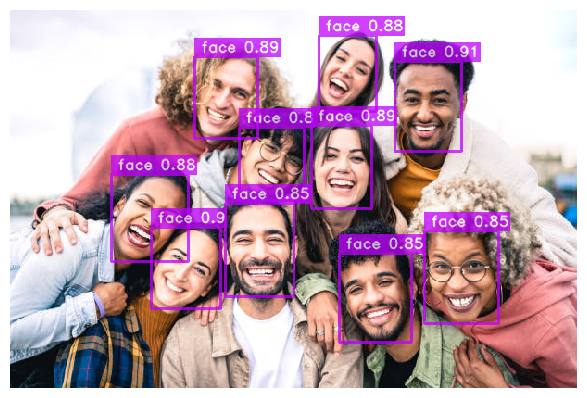

In [ ]:
img_1 = "/content/drive/MyDrive/istockphoto-1368965646-612x612.jpg"
best_model.predict(img_1).show()

In [ ]:
preds = best_model.predict('/content/drive/MyDrive/istockphoto-1368965646-612x612.jpg')

[2024-01-18 23:56:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


In [ ]:
def get_rectangle(preds):
    return preds[0].prediction.bboxes_xyxy

In [ ]:
rect = get_rectangle(preds)[0]

In [ ]:
def rect_to_bb(rect):
    x = rect[2] - ((rect[2] - rect[0]) / 2)
    y = rect[3] - ((rect[3] - rect[1]) / 2)
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    return (x, y, w, h)

In [ ]:
bbox = rect_to_bb(rect)

In [ ]:
def shape_to_np(shape, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

In [ ]:
pil = Image.open('/content/drive/MyDrive/istockphoto-1368965646-612x612.jpg')

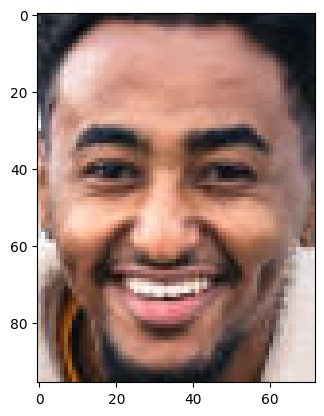

In [ ]:
croped_img = get_cropped_face(rect, bbox, preds[0].image)

# Face Align

Функция для кропа лиц по bbox с выхода модели

In [ ]:
def get_cropped_face(rect, bb, image):
    to_tensor = tfs.Compose([
        tfs.ToTensor()
    ])

    to_pil = tfs.Compose([
        tfs.ToPILImage()
    ])

    croped_img = tfs.functional.crop(img=to_pil(image),
                                     top=rect[1],
                                     left=rect[0],
                                     height=bb[3],
                                     width=bb[2])

    tensor_img = to_tensor(croped_img)
    plt.imshow(tensor_img.permute(1, 2, 0).numpy())
    plt.show();
    return tensor_img

В качестве модели для вырванивания лиц была выбрана предобученная модель из dlib

In [ ]:
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [ ]:
def rect_to_dlib_rect(rect):
    return dlib.rectangle(int(rect[0]), int(rect[1]), int(rect[2]), int(rect[3]))

In [ ]:
dlib_rect = rect_to_dlib_rect(rect)
img = preds[0].image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
shape = predictor(gray, dlib_rect)

In [ ]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    # return the list of (x, y)-coordinates
    return coords

In [ ]:
shape = shape_to_np(shape)

In [ ]:
def get_landmarks(image, shape):
    image = copy.deepcopy(image)
    for (x, y) in shape:
        cv2.circle(image, (x, y), radius=0, color=(255, 0, 0), thickness=-1)
    image = get_cropped_face(rect, bbox, image)
    return image


Лица будут выравниватся по 68 точкам

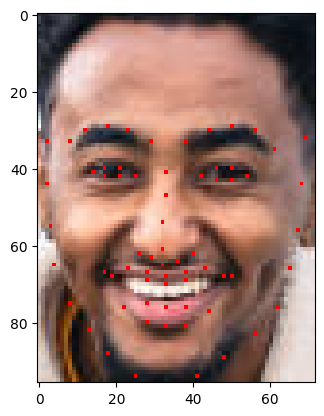

In [ ]:
img = get_landmarks(preds[0].image, shape)

In [ ]:
landmarks_idx = {'left_eye': (36, 41),
                 'right_eye': (42, 47)}

In [ ]:
class FaceAligner:
    def __init__(self, predictor, desiredLeftEye=(0.3, 0.3),
                 desiredFaceWidth=160, desiredFaceHeight=None):
        self.predictor = predictor
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight
        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth

    def align(self, image, rect):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rect = rect_to_dlib_rect(rect)

        shape = self.predictor(gray, rect)
        shape = shape_to_np(shape)

        (lStart, lEnd) = landmarks_idx["left_eye"]
        (rStart, rEnd) = landmarks_idx["right_eye"]
        leftEyePts = shape[lStart:lEnd]
        rightEyePts = shape[rStart:rEnd]
        leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
        rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) - 180
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist
        angle += 180

        eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
                      (leftEyeCenter[1] + rightEyeCenter[1]) // 2)

        M = cv2.getRotationMatrix2D((int(eyesCenter[0]), int(eyesCenter[1])), angle, scale)

        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])
        (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h),
                                flags=cv2.INTER_CUBIC)

        return output

In [ ]:
fa = FaceAligner(predictor)
res = fa.align(preds[0].image, rect)

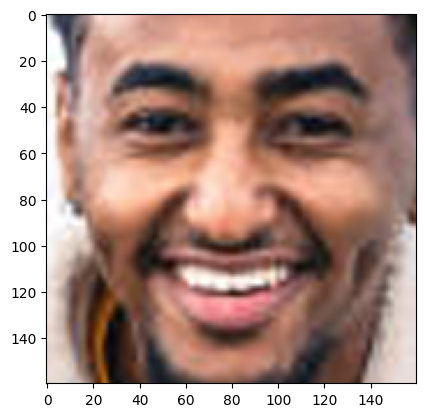

In [ ]:
plt.imshow(res)

In [ ]:
test_rects = get_rectangle(preds)
cropped_imgs = []
for i in range(len(test_rects)):
    cropped_imgs.append(fa.align(preds[0].image, test_rects[i]))

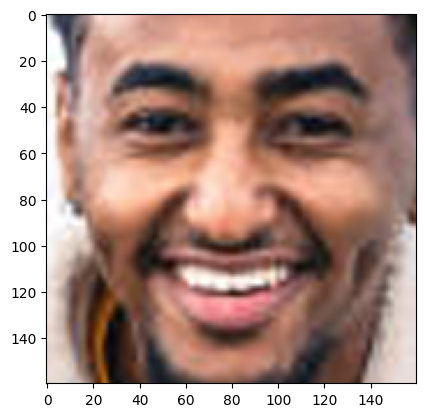

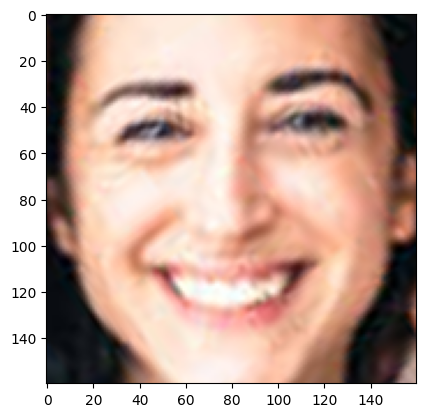

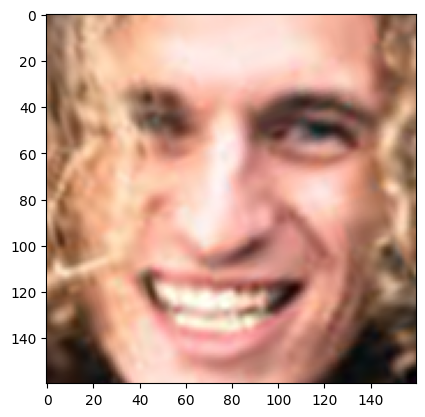

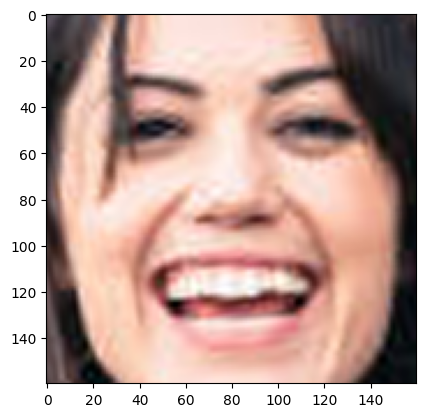

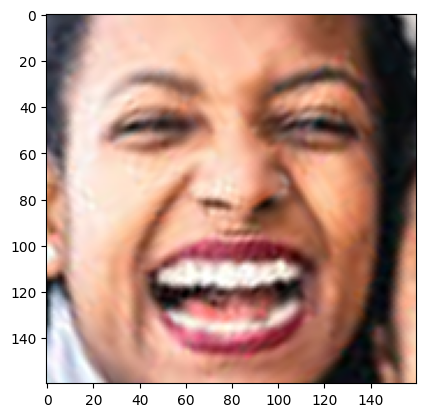

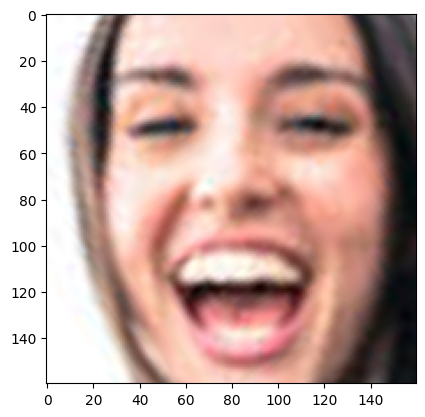

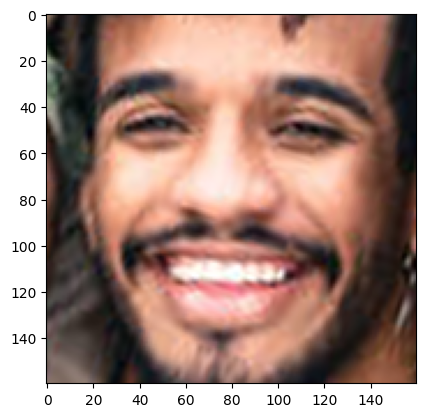

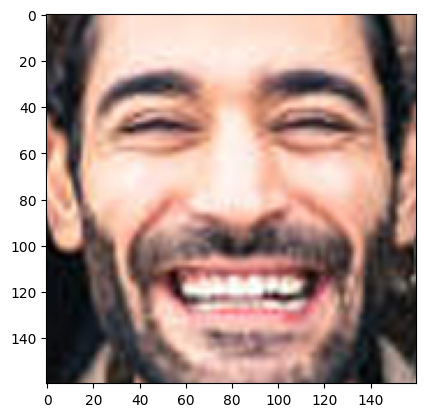

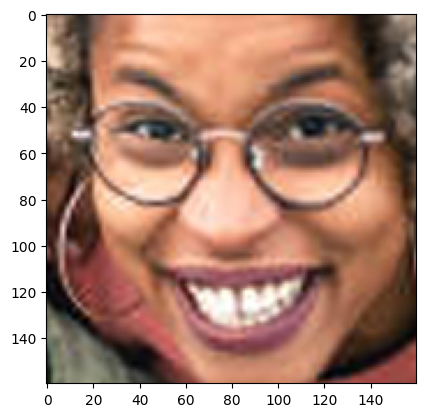

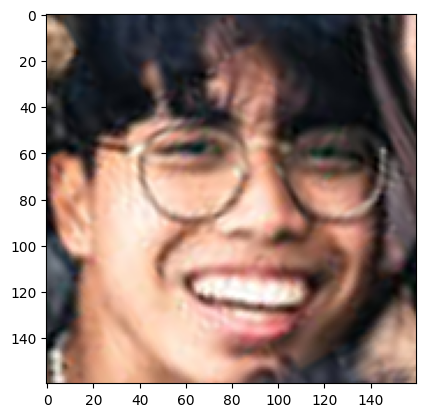

In [ ]:
for i in range(len(cropped_imgs)):
    plt.imshow(cropped_imgs[i])
    plt.show();

Как можно заметить модель очень неплохо выравнивает лица

# Face extracting pipeline
# (Detection + Align)

Данный класс представляет из себя пайплайн для подготовки данных для модели распознавания лиц. Пайплайн принимает навход картинку, а на выходе возвращает массив обрезанных и выровненных лиц.

In [ ]:
class FaceExtractor:
    def __init__(self, face_imgs_width: int, detector_path: str, aligner_path: str):
        self.face_width = face_imgs_width
        self.landmarks_idx = {'left_eye': (36, 41),
                              'right_eye': (42, 47)}
        self.device = 'cpu'
        self.detector = models.get(
            'yolo_nas_l',
            num_classes=1,
            checkpoint_path=detector_path
        ).to(self.device)
        self.aligner = dlib.shape_predictor(aligner_path)

    def to(self, device):
        self.device = device

    def show_detected_faces(self, img_path: str):
        prediction = self.detector.predict(img_path)[0]
        return prediction.show()

    def detect(self, img_path: str):
        return self.detector.predict(img_path)[0]

    def extract_faces(self, img_path: str):
        preds = self.detector.predict(img_path)[0]
        image = preds.image
        rects = self.get_rectangle(preds)
        fa = FaceAligner(self.aligner, desiredFaceWidth=self.face_width)
        align_faces = []
        for rect in rects:
            align_face = fa.align(image, rect)
            align_faces.append(align_face)
        return align_faces

    def get_rectangle(self, detected_faces):
        return detected_faces.prediction.bboxes_xyxy

    def get_landmarks(self, image: np.array):
        image = copy.deepcopy(image)
        for (x, y) in shape:
            cv2.circle(image, (x, y), radius=0, color=(255, 0, 0), thickness=-1)
        image = self.get_cropped_face(rect, bbox, image)
        return image

    def get_cropped_face(self, rect, bb, image):
        to_tensor = tfs.Compose([
            tfs.ToTensor()
        ])

        to_pil = tfs.Compose([
            tfs.ToPILImage()
        ])

        croped_img = tfs.functional.crop(img=to_pil(image),
                                         top=rect[1],
                                         left=rect[0],
                                         height=bb[3],
                                         width=bb[2])

        tensor_img = to_tensor(croped_img)
        plt.imshow(tensor_img.permute(1, 2, 0).numpy())
        return tensor_img

    def shape_to_np(shape, dtype="int"):
        coords = np.zeros((68, 2), dtype=dtype)
        for i in range(0, 68):
            coords[i] = (shape.part(i).x, shape.part(i).y)
        return coords



In [ ]:
model = FaceExtractor(256)
imgs = model.extract_faces('/content/drive/MyDrive/istockphoto-1480574526-612x612.jpg')

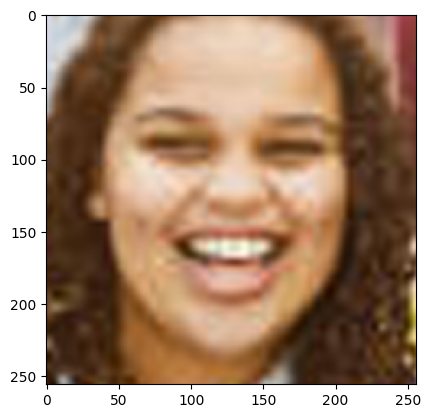

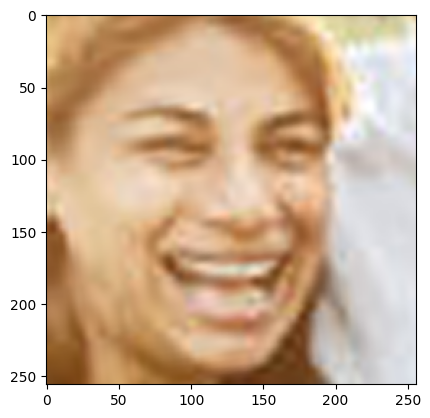

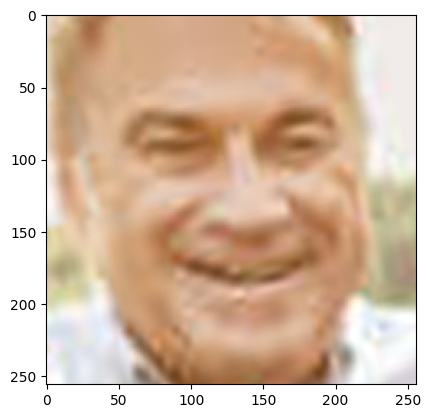

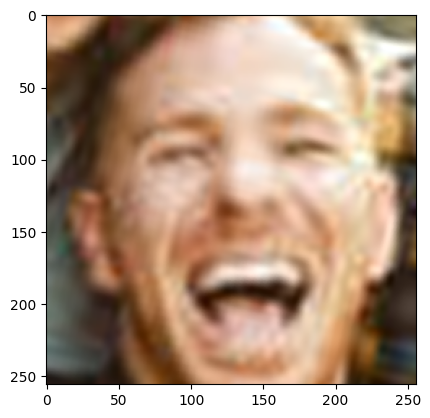

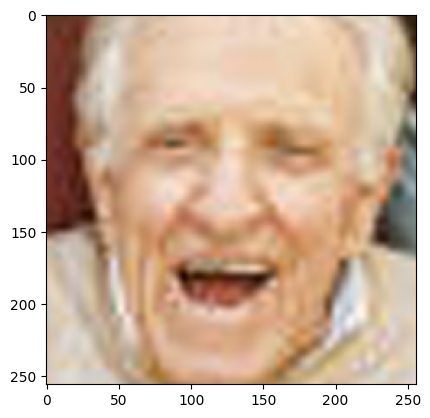

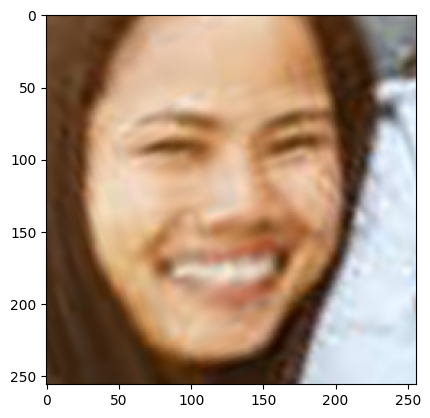

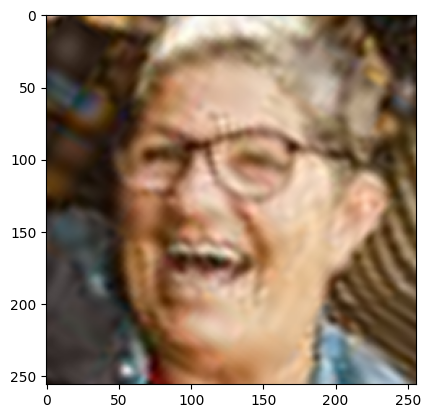

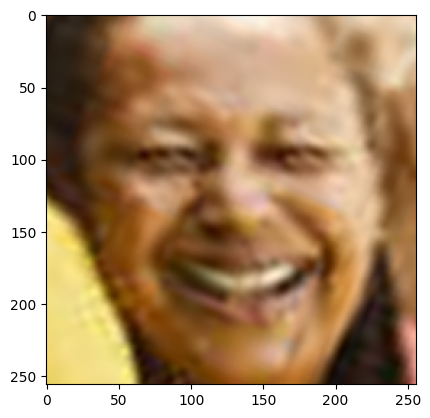

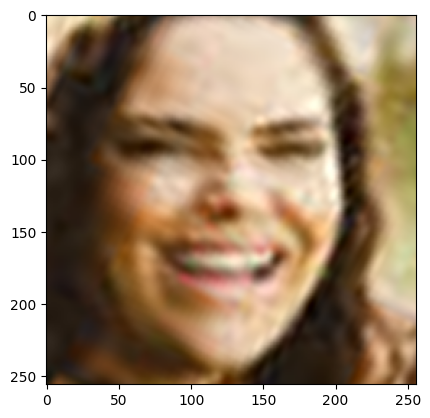

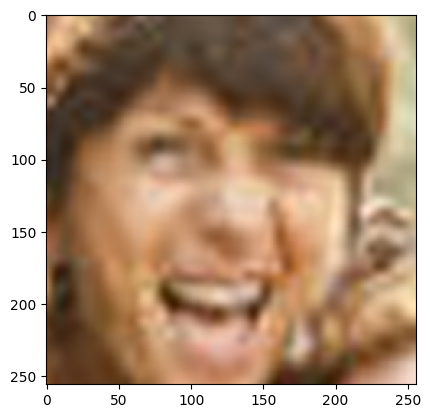

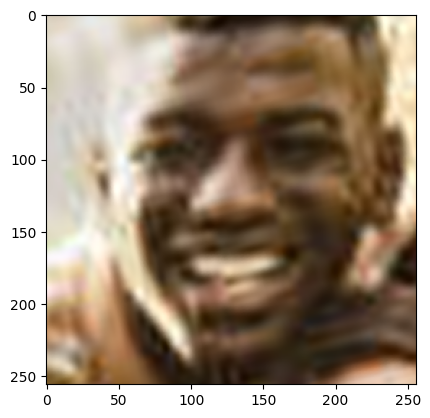

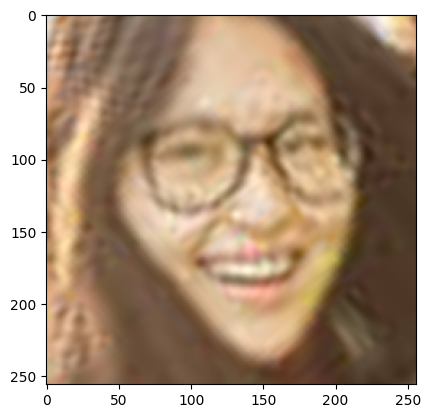

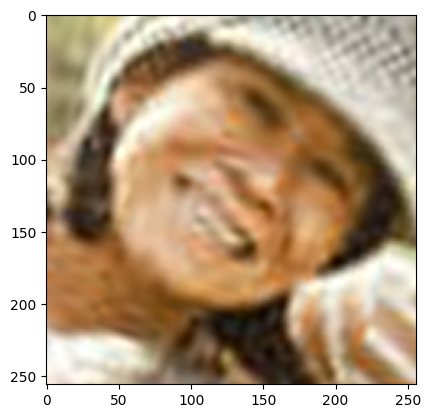

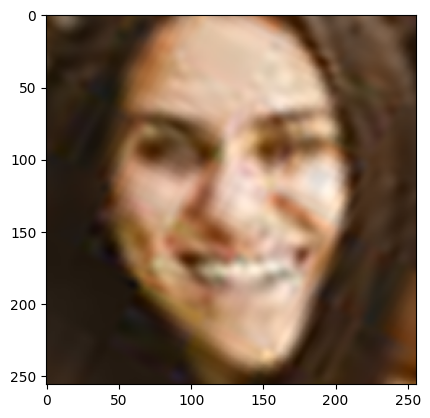

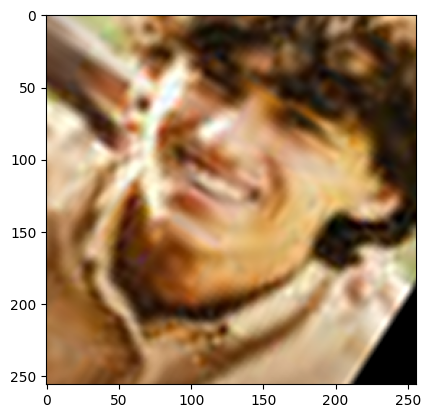

In [ ]:
for i in range(len(imgs)):
    plt.imshow(imgs[i])
    plt.show();

# Face Recognition

Почитав статьи про эмбединги лиц, принял решение в качестве первого эксперемента использовать backbone от resnet-50 с весами с imagenet.

In [ ]:
!unzip/content/drive/MyDrive/celebA_ir.zip

In [ ]:
!unzip/content/drive/MyDrive/celebA_train_500.zip

Для использования данного нам датасета celeba_500 необходимо написать класс кастомного датасета

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import os


class CustomImageDataset(Dataset):
    def __init__(self, data_anno_path, train_split, root_dir, subset, transform=None):
        self.subset = subset
        self.data_anno_path = data_anno_path
        self.data_train_split_path = train_split
        self.root_dir = root_dir
        self.transform = transform
        self.data = self._read_txt_file()

    def _read_txt_file(self):
        with open(self.data_anno_path) as f:
            with open(self.data_train_split_path) as d:
                annot = sorted(f.readlines())
                annots = {'0': 'train',
                          '1': 'val',
                          '2': 'test'}
                train_split = sorted(d.readlines())
                data = []
                for i in range(len(annot)):
                    if annots[train_split[i].split()[1]] == self.subset:
                        annot[i] = annot[i].split()
                        annot[i].append(train_split[i].split()[1])
                        data.append((annot[i][0], int(annot[i][1]), annots[annot[i][2]]))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label, subset = self.data[idx]
        image = np.array(Image.open(os.path.join(self.root_dir, img_path)))
        image = Image.fromarray(image[77:-41, 45:-50])
        if self.transform:
            image = self.transform(image)

        return (image, label)


Картинки будут иметь фиксированный размер 160x160

In [ ]:
data_anno_path = r'celeba\celebA_anno.txt'
train_split = r'celeba\celebA_train_split.txt'
root_dir = r'celeba\celebA_imgs'
transforms = tfs.Compose([
    tfs.ToTensor(),
    tfs.Resize((160, 160)),
    tfs.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_set = CustomImageDataset(data_anno_path, train_split, root_dir, 'train', transforms)
val_set = CustomImageDataset(data_anno_path, train_split, root_dir, 'val', transforms)
test_set = CustomImageDataset(data_anno_path, train_split, root_dir, 'test', transforms)

In [ ]:
len(train_set), len(val_set), len(test_set)

(8544, 1878, 1589)

In [ ]:
trainloader = DataLoader(train_set, batch_size=128, shuffle=True)
valloader = DataLoader(val_set, batch_size=128, shuffle=False)
testloader = DataLoader(test_set, batch_size=128, shuffle=True)

[2024-01-18 10:38:20] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


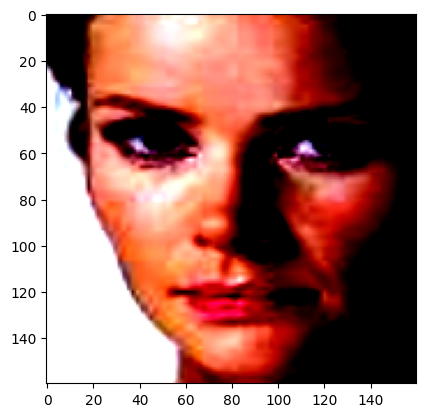

In [ ]:
plt.imshow(next(iter(trainloader))[0][0].to('cpu').detach().permute(1, 2, 0))

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)

In [ ]:
from torch import nn
from torchsummary import summary
import torchmetrics

summary(model, (3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           9,408
       BatchNorm2d-2           [-1, 64, 80, 80]             128
              ReLU-3           [-1, 64, 80, 80]               0
         MaxPool2d-4           [-1, 64, 40, 40]               0
            Conv2d-5           [-1, 64, 40, 40]           4,096
       BatchNorm2d-6           [-1, 64, 40, 40]             128
              ReLU-7           [-1, 64, 40, 40]               0
            Conv2d-8           [-1, 64, 40, 40]          36,864
       BatchNorm2d-9           [-1, 64, 40, 40]             128
             ReLU-10           [-1, 64, 40, 40]               0
           Conv2d-11          [-1, 256, 40, 40]          16,384
      BatchNorm2d-12          [-1, 256, 40, 40]             512
           Conv2d-13          [-1, 256, 40, 40]          16,384
      BatchNorm2d-14          [-1, 256,

Заморозим только первый слой модели (обычно самые начальные слои отвечают за самые общие признаки и в дообучение не нуждаются)

In [ ]:
for param in model.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer2.parameters():
    param.requires_grad = True
model.fc = nn.Linear(2048, 500).to(device)
model.fc.requires_grad = True

In [ ]:
loss_fn = nn.CrossEntropyLoss()
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
metric = torchmetrics.Accuracy(num_classes=500, ).to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.5, verbose=1)

In [ ]:
def train_loop(model, epochs, loss_fn, optimizer, metric, trainloader, valloader, scheduler=None):
    results = {'train_loss': [],
               'validation_loss': [],
               'train_score': [],
               'validation_score': []}
    for epoch in range(epochs):

        epoch_loss = 0
        epoch_score = 0

        for x_batch, y_batch in tqdm(trainloader):
            model.train()
            optimizer.zero_grad()
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outp = model(x_batch)
            train_loss = loss_fn(outp, y_batch)
            if epoch % 3 == 0:
                train_score = metric(outp, y_batch)
                epoch_score += train_score
            epoch_loss += train_loss
            train_loss.backward()
            optimizer.step()

        results['train_loss'].append(epoch_loss / len(trainloader))
        if epoch % 3 == 0:
            results['train_score'].append(epoch_score / len(trainloader))

        epoch_loss = 0
        epoch_score = 0

        model.eval()
        with torch.inference_mode():
            for x_batch, y_batch in valloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outp = model(x_batch).to(device)
                val_loss = loss_fn(outp, y_batch)
                if epoch % 3 == 0:
                    val_score = metric(outp, y_batch)
                    epoch_score += val_score
                epoch_loss += val_loss

        results['validation_loss'].append(epoch_loss / len(valloader))
        if epoch % 3 == 0:
            results['validation_score'].append(epoch_score / len(valloader))

        if scheduler:
            scheduler.step()
        if epoch % 3 == 0:
            print(f"Epoch: {epoch + 1} | train_loss: {results['train_loss'][epoch]} |" +
                  f"val_loss: {results['validation_loss'][epoch]} | train_score: {results['train_score'][-1]} | val_score: {results['validation_score'][-1]}")
        else:
            print(
                f"Epoch: {epoch + 1} | train_loss: {results['train_loss'][epoch]} | val_loss: {results['validation_loss'][epoch]}")
    return results

In [ ]:
results = train_loop(model, epochs, loss_fn, optimizer, metric, trainloader, valloader)

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.332686424255371 |val_loss: 3.4878437519073486 | train_score: 0.07256554067134857 | val_score: 0.2547188103199005


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.1146256923675537 | val_loss: 1.938876748085022


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5284869074821472 | val_loss: 1.711884617805481


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.09583552926778793 |val_loss: 1.432990312576294 | train_score: 0.9885299801826477 | val_score: 0.6758474707603455


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.01690668985247612 | val_loss: 1.289093017578125


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 0.00722900265827775 | val_loss: 1.267505407333374


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 0.006756678689271212 |val_loss: 1.379955768585205 | train_score: 0.9992977380752563 | val_score: 0.7009823322296143


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 0.0035414027515798807 | val_loss: 1.2913912534713745


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 0.0018513653194531798 | val_loss: 1.2873377799987793


In [ ]:
torch.save(model.state_dict(), 'resnet50.pth')

In [ ]:
accuracy = []
for x, y in testloader:
    x, y = x.to(device), y.to(device)
    with torch.inference_mode():
        model.eval()
        preds = model(x)
        acc = metric(preds, y)
        accuracy.append(acc)
res = sum(accuracy) / len(accuracy)

In [ ]:
res

tensor(0.7296, device='cuda:0')

In [ ]:
def plot_train_curve(results):
    plt.figure(figsize=(14, 6), dpi=100)
    plt.subplot(1, 2, 1)
    train_losses = [x.to('cpu').detach() for x in results['train_loss']]
    val_losses = [x.to('cpu').detach() for x in results['validation_loss']]
    plt.plot(train_losses, label='train loss')
    plt.title('Loss:')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.plot(val_losses, label='validation loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    train_score = [x.to('cpu').detach() for x in results['train_score']]
    val_score = [x.to('cpu').detach() for x in results['validation_score']]
    plt.plot(train_score, label='train accuracy')
    plt.plot(val_score, label='validation accuracy')
    plt.legend()
    plt.title('Accuracy score:')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.show();

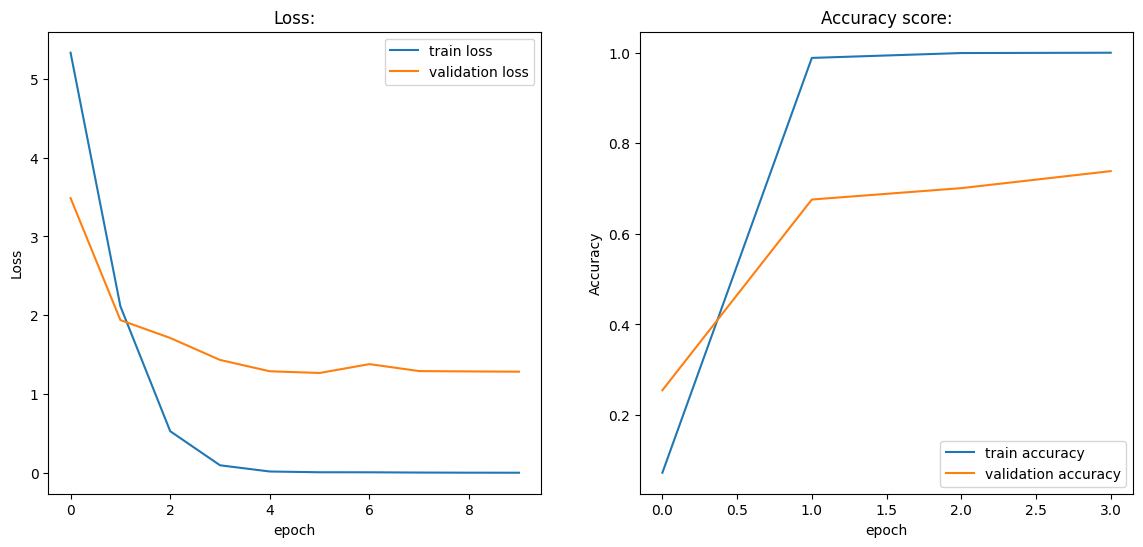

In [ ]:
plot_train_curve(results)

**Метрика в 0.7 accuracy на CE функции потерь достигнута за 10 эпох. Дальнейшее обучение модели не дало никаких существенных улучшений метрики**

# Full pipeline (detection + align + encoding)

Identity мы будем использовать для удаления из сети линейного выходного слоя

In [ ]:
from torch import nn
from torchvision.models import resnet50


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
encoder = copy.deepcopy(model)

In [ ]:
torch.save(encoder.state_dict(), 'resnet_encoder.pth')

In [ ]:
encoder.fc = Identity()

In [ ]:
class FaceRecognition(FaceExtractor):
    def __init__(self, aligner_path: str, encoder_path: str, detector_path: str, treshold: float, face_imgs_width=160):
        """
          aligner_path: str, path to align model's weights.
          encoder_path: str, path to encoder model's weights.
          detector_path: str, path to detector model's weights.
          treshold: float, cosine similarity treshold (value between 0. and 1.)
        """
        super().__init__(face_imgs_width, detector_path, aligner_path)
        self.treshold = treshold
        self.encoder = self.resnet_encoder(encoder_path)
        self.encoder.eval()
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize((160, 160)),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def resnet_encoder(self, encoder_path: str):
        encoder = resnet50(weights=None)
        encoder.fc = Identity()
        encoder.load_state_dict(torch.load(encoder_path))
        return encoder.to(self.device)

    def encode_aligned_faces(self, imgs: list):
        img = torch.stack([self.transform(img) for img in imgs])
        with torch.inference_mode():
            embeddings = self.encoder(img)
            return embeddings

    def cosine_similarity(self,
                          a: torch.Tensor,
                          b: torch.Tensor):
        if a.shape[0] != b.shape[0]:
            raise Exception("A tensor's number of samples must be equal to B tensor")
        batch_size = a.shape[0]
        cosine_similarities = []
        for elem in range(a.shape[0]):
            dot_product = torch.dot(a[elem], b[elem])
            len_a = torch.sqrt(torch.sum(a[elem] ** 2))
            len_b = torch.sqrt(torch.sum(b[elem] ** 2))
            cosine_similarity = 1 - (dot_product / (len_a * len_b))
            cosine_similarities.append(cosine_similarity)
        return cosine_similarities

    def encode_faces_from_img(self, img_path: str):
        aligned_faces = self.extract_faces(img_path)
        aligned_faces = [self.transform(img).to(self.device) for img in aligned_faces]
        embeddings = [(img, self.encoder(img.unsqueeze(0))) for img in aligned_faces]
        return embeddings

    def find_similar(self, img_path: str, data: list):
        """
        img_path: str, image path to exctract faces.
        data: list, (embedding, id) faces dataset.
        """
        embeddings = self.encode_faces_from_img(img_path)
        similar_faces = []
        for (img, embedding) in embeddings:
            similar = [x[1] for x in data if self.cosine_similarity(embedding, x[0]) >= self.treshold]
            similar_faces.append((img, similar))
        return similar_faces

In [ ]:
aligner_path = 'shape_predictor_68_face_landmarks.dat'
encoder_path = 'resnet_encoder.pth'
detector_path = 'detection_checkpoints/average_model.pth'
final_model = FaceRecognition(aligner_path, encoder_path, detector_path, treshold=0.5)

[2024-01-19 00:28:45] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/average_model.pth EMA checkpoint.


In [ ]:
preds = final_model.encode_faces_from_img('/content/drive/MyDrive/istockphoto-1368965646-612x612.jpg')

[2024-01-18 12:50:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


[2024-01-18 13:07:41] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2024-01-18 13:07:41] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2024-01-18 13:07:41] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2024-01-18 13:07:41] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2024-01-18 13:07:41] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2024-01-18 13:07:41] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2024-01-18 13:07:41] WARNING - image.py - Clipping input data to the valid range 

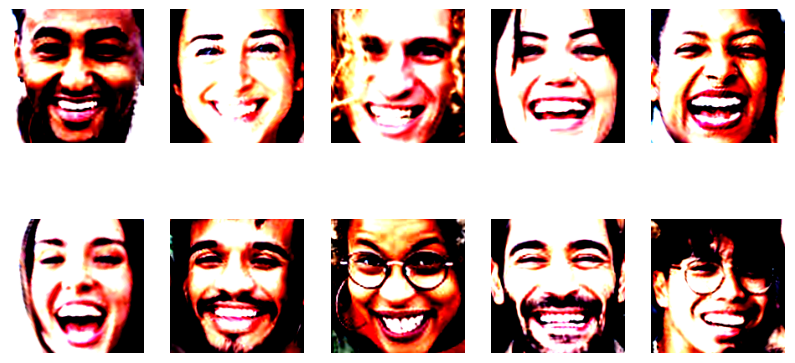

In [ ]:
fig, axs = plt.subplots(len(preds) // 5, len(preds) // 2, figsize=(10, 5))
axs = axs.flatten()
for index, ax in enumerate(axs):
    ax.imshow(preds[index][0].to('cpu').permute(1, 2, 0).detach())
    ax.set_axis_off()

In [ ]:
torch.save(model.state_dict(), 'resnet.pth')

# TripletLoss

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        cos_pos_dist = self.cosine_distance(anchor, positive)
        cos_neg_dist = self.cosine_distance(anchor, negative)

        losses = []
        for i in range(len(cos_pos_dist)):
            loss = torch.max(cos_pos_dist[i] - cos_neg_dist[i] + self.margin, torch.tensor(0.0, device=anchor.device))
            losses.append(loss)

        loss = torch.mean(torch.stack(losses))
        return loss

    def cosine_distance(self, a, b):
        if a.shape[0] != b.shape[0]:
            raise Exception("A tensor's number of samples must be equal to B tensor")

        batch_size = a.shape[0]
        cosine_distances = []

        for elem in range(batch_size):
            dot_product = torch.dot(a[elem], b[elem])
            len_a = torch.sqrt(torch.sum(a[elem] ** 2))
            len_b = torch.sqrt(torch.sum(b[elem] ** 2))
            cosine_distance = 1 - (dot_product / (len_a * len_b))
            cosine_distances.append(cosine_distance)

        return cosine_distances

Подготовка данных для удобного использования

In [ ]:
import shutil
import os

root_dir_new = r'/content/drive/MyDrive/custom_celeba_500'
data_anno_path = r'/content/celebA_train_500/celebA_anno.txt'
train_split = r'/content/celebA_train_500/celebA_train_split.txt'
root_dir = r'/content/celebA_train_500/celebA_imgs'
sets = ['train', 'val', 'test']
for _set in sets:
    dir_path = os.path.join(root_dir_new, _set)
    for dir_idx in range(500):
        dir_path_idx = os.path.join(dir_path, str(dir_idx))
        if not os.path.exists(dir_path_idx):
            os.mkdir(dir_path_idx)



In [ ]:
with open(data_anno_path) as f:
    with open(train_split) as d:
        annots = sorted(f.readlines())
        subsets = sorted(d.readlines())
        for idx in range(len(annots)):
            annots[idx] = annots[idx].split()
            annots[idx].append(subsets[idx].split()[-1])
            subsets_dict = {'0': 'train',
                            '1': 'val',
                            '2': 'test'}
            subset_name = subsets_dict[annots[idx][-1]]
            subset_path = os.path.join(root_dir_new, subset_name)
            img_dir = os.path.join(subset_path, annots[idx][1])
            if not os.path.exists(os.path.join(img_dir, annots[idx][0])):
                shutil.copy(os.path.join(root_dir, annots[idx][0]), img_dir)

In [ ]:
subsets = ['custom_celeba_500/test',
           'custom_celeba_500/train',
           'custom_celeba_500/val']
for subset in subsets:
    for idx in range(500):
        path = os.path.join(subset, str(idx))
        if len(os.listdir(path)) <= 1:
            if len(os.listdir(path)) == 0:
                shutil.rmtree(path)
            else:
                os.remove(os.path.join(path, os.listdir(path)[0]))
                shutil.rmtree(path)


# Custom dataset for TripletLoss

In [ ]:
from torchvision.datasets import ImageFolder
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms as tfs
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
from torch import nn, optim
from tqdm import tqdm
from torch.nn.functional import normalize
from torch.nn import functional as F
import torchsummary

torch.manual_seed(42)

In [ ]:
class TripletImageFolder(ImageFolder):
    def __init__(self, subset=None, *arg, **kw):
        super(TripletImageFolder, self).__init__(*arg, **kw)

        self.subset = subset
        self.n_triplets = len(self.samples)
        self.train_triplets = self.generate_triplets()

    def generate_triplets(self):
        labels = torch.Tensor(self.targets)
        triplets = []

        while len(triplets) < self.n_triplets:
            idx = np.random.randint(0, labels.size(0))
            idx_matches = np.where(labels.numpy() == labels[idx].numpy())[0]
            idx_no_matches = np.where(labels.numpy() != labels[idx].numpy())[0]

            idx_a, idx_p = np.random.choice(idx_matches, 2, replace=False)
            idx_n = np.random.choice(idx_no_matches, 1)[0]

            triplet = [idx_a, idx_p, idx_n]

            if triplet not in triplets:
                triplets.append(triplet)

        return np.array(triplets)

    def set_triplets(self, triplets):
        self.train_triplets = triplets

    def __getitem__(self, index):
        t = self.train_triplets[index]

        path_a = self.samples[t[0]][0]
        path_p = self.samples[t[1]][0]
        path_n = self.samples[t[2]][0]

        img_a = self.loader(path_a)
        img_p = self.loader(path_p)
        img_n = self.loader(path_n)

        img_a = np.array(img_a)
        img_a = Image.fromarray(img_a[77:-41, 45:-50])
        img_p = np.array(img_p)
        img_p = Image.fromarray(img_p[77:-41, 45:-50])
        img_n = np.array(img_n)
        img_n = Image.fromarray(img_n[77:-41, 45:-50])

        if self.transform is not None:
            img_a = self.transform(img_a)
            img_p = self.transform(img_p)
            img_n = self.transform(img_n)

        return img_a, img_p, img_n

In [ ]:
transform = tfs.Compose([
    tfs.ToTensor(),
    tfs.Resize((160, 160)),
    tfs.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
trainset = TripletImageFolder(root=r'celeba\custom_celeba_500\train',
                              transform=transform, subset='train')
valset = TripletImageFolder(root=r'celeba\custom_celeba_500\val',
                            transform=transform)
testset = TripletImageFolder(root=r'celeba\custom_celeba_500\test',
                             transform=transform)

In [ ]:
len(trainset), len(valset), len(testset)

(8544, 1860, 1561)

По результатам эксперементов стало ясно, что размер батчсайза очень влияет на поведение модели при обучение на TripletLoss. К сожалению вычислительные ресурсы не позволили взять батчсайз > 128. Использование меньшего батчсайза оказала негативное влияние на сходимость модели

In [ ]:
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, pin_memory=True)
valloader = DataLoader(valset, batch_size=32, pin_memory=True)
testloader = DataLoader(valset, batch_size=32, pin_memory=True)

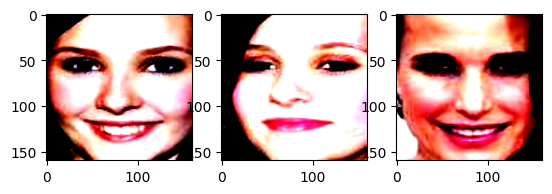

In [ ]:
batch = next(iter(trainloader))
fig, axs = plt.subplots(1, 3)
axs = axs.flatten()
for idx, ax in enumerate(axs):
    ax.imshow(batch[idx][1].permute(1, 2, 0))

# Training resnet50 with TripletLoss

В качестве первой архитектуры использовалась предобученная resnet50 с замороженным первым слоем. Как оказалось позже, выбор других версий реснета или даже других моделей (схожих по количеству пораметров) не сильно влияло на графики лосса.

In [ ]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet_triplet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)
resnet_triplet.fc = nn.Linear(2048, 500).to(device)
for param in resnet_triplet.parameters():
    param.requires_grad = True
for param in resnet_triplet.layer1.parameters():
    param.requires_grad = False
optimizer = optim.AdamW(resnet_triplet.parameters(), 3e-04)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, min_lr=0.00001)
criterion = TripletLoss()

In [ ]:
torchsummary.summary(resnet_triplet, (3, 160, 160))

In [ ]:
def train_loop_triplet(epochs, model, criterion, optimizer, trainloader, valloader, scheduler):
    results = {'train': [],
               'val': []}
    for epoch in range(epochs):

        model.train()
        loss = 0

        for anchor, pos, neg in tqdm(trainloader):
            optimizer.zero_grad()
            anchor = anchor.to(device)
            pos = pos.to(device)
            neg = neg.to(device)
            anch_embd = normalize(model(anchor))
            pos_embd = normalize(model(pos))
            neg_embd = normalize(model(neg))
            train_loss = criterion(anch_embd, pos_embd, neg_embd)
            train_loss.backward()
            optimizer.step()
            loss += train_loss
        results['train'].append(loss / len(trainloader))

        val_loss = 0
        loss = 0
        model.eval()
        with torch.inference_mode():
            for anchor, pos, neg in tqdm(valloader):
                anchor = anchor.to(device)
                pos = pos.to(device)
                neg = neg.to(device)
                anch_embd = normalize(model(anchor))
                pos_embd = normalize(model(pos))
                neg_embd = normalize(model(neg))
                val_loss += criterion(anch_embd, pos_embd, neg_embd)
        scheduler.step(val_loss)

        results['val'].append(val_loss / len(valloader))
        print(f"Epoch: {epoch + 1} | train_loss: {results['train'][-1]} | val_loss: {results['val'][-1]}")
    return results



In [ ]:
res = train_loop_triplet(7, resnet_triplet, criterion, optimizer, trainloader, valloader)

100%|██████████| 59/59 [00:14<00:00,  4.17it/s]


Epoch: 1 | train_loss: 0.3446199893951416 | val_loss: 0.39457201957702637


100%|██████████| 59/59 [00:14<00:00,  4.13it/s]


Epoch: 2 | train_loss: 0.279790461063385 | val_loss: 0.3720099925994873


100%|██████████| 59/59 [00:14<00:00,  4.12it/s]


Epoch: 3 | train_loss: 0.2277073711156845 | val_loss: 0.35777992010116577


100%|██████████| 59/59 [00:14<00:00,  4.12it/s]


Epoch: 4 | train_loss: 0.1925678700208664 | val_loss: 0.3819713592529297


100%|██████████| 59/59 [00:17<00:00,  3.35it/s]


Epoch: 5 | train_loss: 0.16139936447143555 | val_loss: 0.38178327679634094


100%|██████████| 59/59 [00:18<00:00,  3.22it/s]


Epoch: 6 | train_loss: 0.1401788294315338 | val_loss: 0.3649176359176636


100%|██████████| 59/59 [00:15<00:00,  3.74it/s]


Epoch: 7 | train_loss: 0.12378792464733124 | val_loss: 0.35078051686286926


In [ ]:
torch.save(resnet_triplet.state_dict(), r'C:\Users\annam\PycharmProjects\pythonProject15\triplet_model.pth')

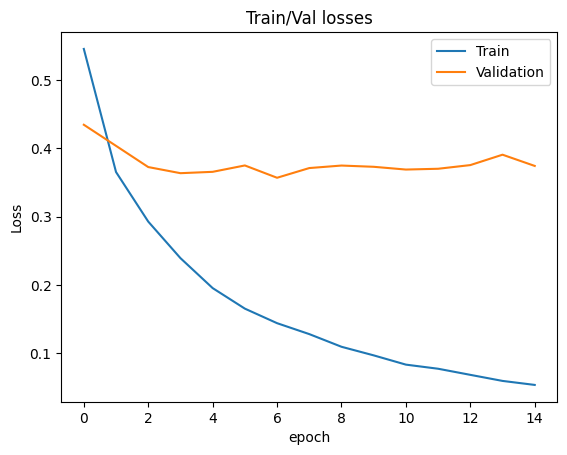

In [ ]:
plt.plot([x.to('cpu').detach() for x in res['train']], label='Train')
plt.plot([x.to('cpu').detach() for x in res['val']], label='Validation')
plt.title('Train/Val losses')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend();

In [ ]:
f"AdamW/500 embd size. Lowest val_loss {min(res['val'])}"

'AdamW/ 1000 embd size. Lowest val_loss 0.37191277742385864'

In [ ]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet_triplet_3 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)
resnet_triplet_3.fc = nn.Linear(2048, 300).to(device)
for param in resnet_triplet_3.parameters():
    param.requires_grad = True
for param in resnet_triplet_3.layer1.parameters():
    param.requires_grad = False
optimizer = optim.AdamW(resnet_triplet_3.parameters(), 3e-04)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, min_lr=0.00001)
criterion = TripletLoss()

In [ ]:
res = train_loop_triplet(15, resnet_triplet_3, criterion, optimizer, trainloader, valloader)

100%|██████████| 59/59 [00:29<00:00,  2.02it/s]


Epoch: 1 | train_loss: 0.5561605095863342 | val_loss: 0.46407753229141235


100%|██████████| 59/59 [00:29<00:00,  2.03it/s]


Epoch: 2 | train_loss: 0.370768278837204 | val_loss: 0.4129568338394165


100%|██████████| 59/59 [00:31<00:00,  1.89it/s]


Epoch: 3 | train_loss: 0.29212522506713867 | val_loss: 0.38837000727653503


100%|██████████| 59/59 [00:33<00:00,  1.79it/s]


Epoch: 4 | train_loss: 0.23791289329528809 | val_loss: 0.37902161478996277


100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


Epoch: 5 | train_loss: 0.1975063979625702 | val_loss: 0.38885313272476196


100%|██████████| 59/59 [00:23<00:00,  2.51it/s]


Epoch: 6 | train_loss: 0.16535910964012146 | val_loss: 0.363862544298172


100%|██████████| 59/59 [00:23<00:00,  2.53it/s]


Epoch: 7 | train_loss: 0.14324085414409637 | val_loss: 0.38794970512390137


100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


Epoch: 8 | train_loss: 0.12711329758167267 | val_loss: 0.3714659810066223


100%|██████████| 59/59 [00:25<00:00,  2.34it/s]


Epoch: 9 | train_loss: 0.105880506336689 | val_loss: 0.37680503726005554


100%|██████████| 59/59 [00:23<00:00,  2.48it/s]


Epoch: 10 | train_loss: 0.09292370080947876 | val_loss: 0.36787694692611694


100%|██████████| 59/59 [00:23<00:00,  2.51it/s]


Epoch: 11 | train_loss: 0.08157048374414444 | val_loss: 0.38659361004829407


100%|██████████| 59/59 [00:23<00:00,  2.46it/s]


Epoch: 12 | train_loss: 0.06962243467569351 | val_loss: 0.38261649012565613


100%|██████████| 59/59 [00:22<00:00,  2.62it/s]


Epoch: 13 | train_loss: 0.06582869589328766 | val_loss: 0.379290372133255


100%|██████████| 59/59 [00:23<00:00,  2.54it/s]


Epoch: 14 | train_loss: 0.05725030601024628 | val_loss: 0.38427114486694336


  1%|          | 3/267 [00:04<05:57,  1.35s/it]


KeyboardInterrupt: 

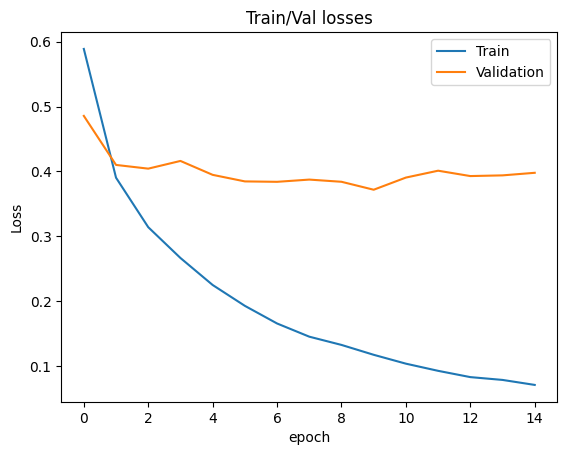

In [ ]:
plt.plot([x.to('cpu').detach() for x in res['train']], label='Train')
plt.plot([x.to('cpu').detach() for x in res['val']], label='Validation')
plt.title('Train/Val losses')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend();

In [ ]:
f"AdamW/300 embd size. Lowest val_loss {min(res['val'])}"

'AdamW/300 embd size. Lowest val_loss 0.37191277742385864'

In [ ]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet_triplet_sgd = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)
resnet_triplet_sgd.fc = nn.Linear(2048, 500).to(device)
for param in resnet_triplet_sgd.parameters():
    param.requires_grad = True
for param in resnet_triplet_sgd.layer1.parameters():
    param.requires_grad = False
optimizer = optim.SGD(resnet_triplet_sgd.parameters(), 3e-04)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=3e-04, max_lr=0.01, )
criterion = TripletLoss()

In [ ]:
def train_loop_triplet_2(epochs, model, criterion, optimizer, trainloader, valloader):
    results = {'train': [],
               'val': []}
    for epoch in range(epochs):

        model.train()
        train_loss = 0
        loss = 0

        for anchor, pos, neg in tqdm(trainloader):
            optimizer.zero_grad()
            anchor = anchor.to(device)
            pos = pos.to(device)
            neg = neg.to(device)
            anch_embd = normalize(model(anchor))
            pos_embd = normalize(model(pos))
            neg_embd = normalize(model(neg))
            train_loss = criterion(anch_embd, pos_embd, neg_embd)
            train_loss.backward()
            #optimizer.step()
            loss += train_loss
        results['train'].append(loss / len(trainloader))

        val_loss = 0
        loss = 0
        model.eval()
        with torch.inference_mode():
            for anchor, pos, neg in tqdm(valloader):
                anchor = anchor.to(device)
                pos = pos.to(device)
                neg = neg.to(device)
                anch_embd = normalize(model(anchor))
                pos_embd = normalize(model(pos))
                neg_embd = normalize(model(neg))
                val_loss += criterion(anch_embd, pos_embd, neg_embd)

        results['val'].append(val_loss / len(valloader))
        print(f"Epoch: {epoch + 1} | train_loss: {results['train'][-1]} | val_loss: {results['val'][-1]}")
    return results


In [ ]:
res_sgd = train_loop_triplet(50, resnet_triplet_sgd, criterion, optimizer, trainloader, valloader)

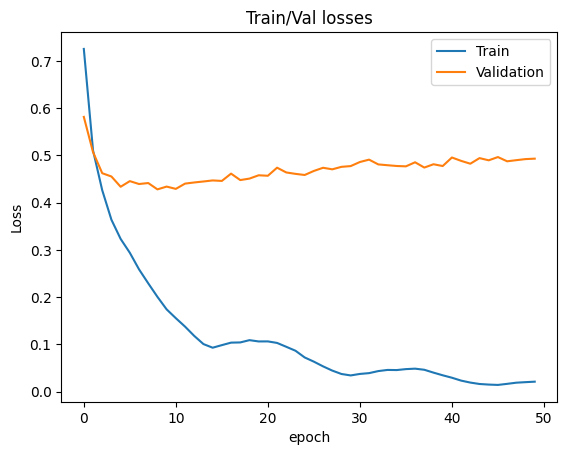

In [ ]:
plt.plot([x.to('cpu').detach() for x in res_sgd['train']], label='Train')
plt.plot([x.to('cpu').detach() for x in res_sgd['val']], label='Validation')
plt.title('Train/Val losses')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend();

In [ ]:
f"SGD/300 embd size. Lowest val_loss {min(res_sgd['val'])}"

'SGD/300 embd size. Lowest val_loss 0.4279952049255371'

Лучшие результаты показала
model: resnet50
output layer: Linear(out_features=500)
optimizer: AdamW(lr=3e-04)

# Identification rate

Для оценки моделей была выбрана метрика Identification rate

In [ ]:
def cosine_similarity(
        a: torch.Tensor,
        b: torch.Tensor):
    if a.shape[0] != b.shape[0]:
        raise Exception("A tensor's number of samples must be equal to B tensor")
    batch_size = a.shape[0]
    cosine_similarities = []
    for elem in range(a.shape[0]):
        dot_product = torch.dot(a[elem], b[elem])
        len_a = torch.sqrt(torch.sum(a[elem] ** 2))
        len_b = torch.sqrt(torch.sum(b[elem] ** 2))
        cosine_similarity = dot_product / (len_a * len_b)
        cosine_similarities.append(cosine_similarity)
    return torch.mean(torch.stack(cosine_similarities))

In [ ]:
from collections import defaultdict
import os

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open(r'C:\Users\annam\PycharmProjects\pythonProject15\celebA_qd\celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
    query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir(r'C:\Users\annam\PycharmProjects\pythonProject15\celebA_qd\celebA_distractors')

In [ ]:
def preprocess_image(img_path):
    img = Image.open(img_path)
    transform = tfs.Compose([
        tfs.ToTensor(),
        tfs.Resize((160, 160)),
        tfs.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = transform(img)
    return img

In [ ]:
def compute_embeddings(model, images_list, root_dir, normal=True):
    '''
    compute embeddings from the trained model for list of images.
    params:
      model: trained nn model that takes images and outputs embeddings
      images_list: list of images paths to compute embeddings for
    output:
      list: list of model embeddings. Each embedding corresponds to images
            names from images_list
    '''
    embds = []
    with torch.inference_mode():
        for img_path in images_list:
            model.eval()
            img_path_r = os.path.join(root_dir, img_path)
            img = preprocess_image(img_path_r).to(device)
            if normal:
                embd = normalize(model(img.unsqueeze(0))).to('cpu')
            else:
                embd = model(img.unsqueeze(0)).to('cpu')
            embds.append((embd, img_path))
    return embds

In [ ]:
device = 'cuda'
resnet_triplet = resnet50(weights=None).to(device)
resnet_triplet.fc = nn.Linear(2048, 500).to(device)
resnet_triplet.load_state_dict(torch.load(r'C:\Users\annam\PycharmProjects\pythonProject15\triplet_model.pth'))

<All keys matched successfully>

In [ ]:
query_embeddings = compute_embeddings(resnet_triplet, query_img_names,
                                      r'C:\Users\annam\PycharmProjects\pythonProject15\celebA_qd\celebA_query')
distactors_embeddings = compute_embeddings(resnet_triplet, distractors_img_names,
                                           r'C:\Users\annam\PycharmProjects\pythonProject15\celebA_qd\celebA_distractors')

C:\Users\annam\venv\pythonProject15\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
def compute_cosine_query_pos(query_dict, query_embeddings):
    '''
    compute cosine similarities between positive pairs from query (stage 1)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding
                      to the same people from query list
    '''
    grouped_embds = [[0] for x in range(len(query_dict.values()))]
    embd_names = [x[1] for x in query_embeddings]
    cos_list = []
    embds = [x[0] for x in query_embeddings]
    for idx, values in enumerate(query_dict.values()):
        for value in values:
            if value in embd_names:
                if type(grouped_embds[idx][0]) != torch.Tensor:
                    grouped_embds[idx] = [query_embeddings[embd_names.index(value)][0]]
                else:
                    grouped_embds[idx].append(query_embeddings[embd_names.index(value)][0])
    grouped_embds = [x for x in grouped_embds if len(x) > 1]
    for group in grouped_embds:
        embed = group[0]
        for embedding in group[1:]:
            cos_list.append(1 - cosine_similarity(embed, embedding))
    return cos_list


def compute_cosine_query_neg(query_dict, query_embeddings):
    '''
    compute cosine similarities between negative pairs from query (stage 2)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding
                      to different people from query list
    '''
    grouped_embds = [[0] for x in range(len(query_dict.values()))]
    embd_names = [x[1] for x in query_embeddings]
    cos_list = []
    embds = [x[0] for x in query_embeddings]
    for idx, values in enumerate(query_dict.values()):
        for value in values:
            if value in embd_names:
                if type(grouped_embds[idx][0]) != torch.Tensor:
                    grouped_embds[idx] = [query_embeddings[embd_names.index(value)][0]]
                else:
                    grouped_embds[idx].append(query_embeddings[embd_names.index(value)][0])
    grouped_embds = [x for x in grouped_embds if len(x) > 1]
    tensor_embds = torch.stack(embds)
    for group in grouped_embds:
        for embedding in group:
            mask = torch.any(tensor_embds != embedding, dim=-1)
            embds_ = tensor_embds[mask]
            cos_list.append(1 - F.cosine_similarity(embedding.to('cuda'), embds_.to('cuda')).to('cpu'))
    return torch.cat(cos_list)


def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
      query_embeddings: list of embeddings corresponding to query_img_names
      distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
      list of floats: similarities between pairs of people (q, d), where q is
                      embedding corresponding to photo from query, d —
                      embedding corresponding to photo from distractors
    '''
    cos_list = []
    distractors_embeddings = torch.stack([x[0] for x in distractors_embeddings])
    for q_emb in query_embeddings:
        dist_embds_mask = torch.any(distractors_embeddings != q_emb[0], dim=-1)
        cos_list.append(
            1 - F.cosine_similarity(q_emb[0].to('cuda'), distractors_embeddings[dist_embds_mask].to('cuda')).to('cpu'))
    return torch.cat(cos_list)

In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distactors_embeddings)

In [ ]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=0.75):
    '''
    compute identification rate using precomputed cosine similarities between pairs
    at a given fpr
    params:
      cosine_query_pos: cosine similarities between positive pairs from query
      cosine_query_neg: cosine similarities between negative pairs from query
      cosine_query_distractors: cosine similarities between negative pairs
                                from query and distractors
      fpr: false positive rate at which to compute TPR
    output:
      float: threshold for given fpr
      float: TPR at given FPR
    '''
    print(f"q_mean: {sum(cosine_query_pos) / len(cosine_query_pos)}\nd_mean: {cosine_query_neg.mean().item()}")
    # Combine negative pairs from query and distractors
    all_neg_cos = torch.cat([torch.tensor(cosine_query_distractors), torch.tensor(cosine_query_neg)])

    # Find the threshold efficiently without sorting the entire list
    threshold_idx = int(fpr * len(all_neg_cos))
    threshold, _ = torch.kthvalue(all_neg_cos, threshold_idx)

    # Convert the threshold to a Python float
    threshold = threshold.item()

    # Calculate TPR at the given FPR
    true_positives = sum(1 for x in cosine_query_pos if x < threshold)
    tpr = true_positives / len(cosine_query_pos)

    return tpr


In [ ]:
print(f"ID_rate: {compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, 0.1)}")

ID_rate: 0.49701110162254486


C:\Users\annam\AppData\Local\Temp\ipykernel_14856\3206475247.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_neg_cos = torch.cat([torch.tensor(cosine_query_distractors), torch.tensor(cosine_query_neg)])


In [ ]:
from torchvision.models import resnet34, ResNet34_Weights

torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet_lb = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).to(device)
cnt = 0
for child in resnet_lb.layer1:
    if not isinstance(child, nn.BatchNorm2d):
        child.requires_grad = False
resnet_lb.fc = nn.Sequential(
    nn.Linear(512, 512),
    nn.Linear(512, 256),
    nn.Linear(256, 128)
).to(device)
optimizer = optim.AdamW(resnet_lb.parameters(), 3e-04)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = TripletLoss(margin=0.3)


In [ ]:
torchsummary.summary(resnet_lb, (3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           9,408
       BatchNorm2d-2           [-1, 64, 80, 80]             128
              ReLU-3           [-1, 64, 80, 80]               0
         MaxPool2d-4           [-1, 64, 40, 40]               0
            Conv2d-5           [-1, 64, 40, 40]          36,864
       BatchNorm2d-6           [-1, 64, 40, 40]             128
              ReLU-7           [-1, 64, 40, 40]               0
            Conv2d-8           [-1, 64, 40, 40]          36,864
       BatchNorm2d-9           [-1, 64, 40, 40]             128
             ReLU-10           [-1, 64, 40, 40]               0
       BasicBlock-11           [-1, 64, 40, 40]               0
           Conv2d-12           [-1, 64, 40, 40]          36,864
      BatchNorm2d-13           [-1, 64, 40, 40]             128
             ReLU-14           [-1, 64,

In [ ]:
res = train_loop_triplet(30, resnet_lb, criterion, optimizer, trainloader, valloader, scheduler=scheduler)

100%|██████████| 30/30 [00:37<00:00,  1.24s/it]


Epoch: 1 | train_loss: 0.12006592750549316 | val_loss: 0.09232894331216812


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Epoch: 2 | train_loss: 0.06214908882975578 | val_loss: 0.09298218786716461


100%|██████████| 30/30 [00:36<00:00,  1.23s/it]


Epoch: 3 | train_loss: 0.04191262647509575 | val_loss: 0.08263487368822098


100%|██████████| 30/30 [00:36<00:00,  1.20s/it]


Epoch: 4 | train_loss: 0.028232641518115997 | val_loss: 0.08169440180063248


100%|██████████| 30/30 [00:35<00:00,  1.20s/it]


Epoch: 5 | train_loss: 0.01828174479305744 | val_loss: 0.0731143206357956


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Epoch: 6 | train_loss: 0.014299056492745876 | val_loss: 0.07140524685382843


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Epoch: 7 | train_loss: 0.010252228938043118 | val_loss: 0.07624585181474686


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Epoch: 8 | train_loss: 0.010689708404242992 | val_loss: 0.06563422083854675


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Epoch: 9 | train_loss: 0.00875743106007576 | val_loss: 0.06402996182441711


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Epoch: 10 | train_loss: 0.007751006633043289 | val_loss: 0.06990248709917068


100%|██████████| 30/30 [00:36<00:00,  1.20s/it]


Epoch: 11 | train_loss: 0.005831422749906778 | val_loss: 0.06894692033529282


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Epoch: 12 | train_loss: 0.0054482389241456985 | val_loss: 0.06501645594835281


100%|██████████| 30/30 [00:36<00:00,  1.20s/it]


Epoch: 13 | train_loss: 0.003919630777090788 | val_loss: 0.05967790633440018


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Epoch: 14 | train_loss: 0.0027074445970356464 | val_loss: 0.058951735496520996


100%|██████████| 30/30 [00:36<00:00,  1.20s/it]


Epoch: 15 | train_loss: 0.0031352394726127386 | val_loss: 0.06599994003772736


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Epoch: 16 | train_loss: 0.0036422847770154476 | val_loss: 0.06373531371355057


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Epoch: 17 | train_loss: 0.003377781016752124 | val_loss: 0.06666331738233566


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Epoch: 18 | train_loss: 0.0034419072326272726 | val_loss: 0.07108189165592194


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Epoch: 19 | train_loss: 0.0035907633136957884 | val_loss: 0.06178596615791321


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Epoch: 20 | train_loss: 0.0031231490429490805 | val_loss: 0.06704173982143402


100%|██████████| 30/30 [00:36<00:00,  1.22s/it]


Epoch: 21 | train_loss: 0.002909360220655799 | val_loss: 0.06998156756162643


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Epoch: 22 | train_loss: 0.003055344335734844 | val_loss: 0.06888682395219803


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Epoch: 23 | train_loss: 0.00452999584376812 | val_loss: 0.06255731731653214


100%|██████████| 30/30 [00:36<00:00,  1.22s/it]


Epoch: 24 | train_loss: 0.003963623195886612 | val_loss: 0.06693021953105927


100%|██████████| 30/30 [00:36<00:00,  1.22s/it]


Epoch: 25 | train_loss: 0.0031218735966831446 | val_loss: 0.06302416324615479


100%|██████████| 30/30 [00:36<00:00,  1.22s/it]


Epoch: 26 | train_loss: 0.003893451299518347 | val_loss: 0.07608118653297424


100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Epoch: 27 | train_loss: 0.00359343271702528 | val_loss: 0.07545889168977737


100%|██████████| 30/30 [00:36<00:00,  1.22s/it]


Epoch: 28 | train_loss: 0.0037657911889255047 | val_loss: 0.0651516541838646


100%|██████████| 30/30 [00:36<00:00,  1.22s/it]


Epoch: 29 | train_loss: 0.003092776285484433 | val_loss: 0.06191231310367584


100%|██████████| 30/30 [00:36<00:00,  1.23s/it]

Epoch: 30 | train_loss: 0.002852105302736163 | val_loss: 0.06293879449367523


In [ ]:
torch.save(resnet_lb.state_dict(), r'resnet_lb')

In [ ]:
from torchvision.models import resnet34

device = 'cuda'
resnet_lb = resnet34(weights=None).to(device)
resnet_lb.fc = nn.Sequential(
    nn.Linear(512, 512),
    nn.Linear(512, 256),
    nn.Linear(256, 128)
).to(device)
resnet_lb.load_state_dict(torch.load(r'resnet_lb'))

<All keys matched successfully>

In [ ]:
resnet_lb.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
query_embeddings = compute_embeddings(resnet_lb, query_img_names,
                                      r'celebA_qd\celebA_query')
distactors_embeddings = compute_embeddings(resnet_lb, distractors_img_names,
                                           r'celebA_qd\celebA_distractors')
cosine_query_pos = compute_cosine_query_pos(query_dict,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distactors_embeddings)

In [ ]:
print(
    f"Resnet50_tripletloss:\nСрднее расстояние в query pos: {sum(cosine_query_pos) / len(cosine_query_pos)}\nСрднее расстояние в query neg: {sum(cosine_query_neg) / len(cosine_query_neg)}\nСрднее расстояние в query/distractors: {sum(cosine_query_distractors) / len(cosine_query_distractors)}")

Resnet50_tripletloss:
Срднее расстояние в query pos: 0.35844841599464417
Срднее расстояние в query neg: 0.9514102935791016
Срднее расстояние в query/distractors: 0.9617745280265808


Так как я использовал similarity а не distance я брал значения > treshold

In [ ]:
fprs = [0.75, 0.5, 0.2, 0.1, 0.01]
for fpr in fprs:
    print(f"FPR={fpr}: {compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=fpr)}")


C:\Users\annam\AppData\Local\Temp\ipykernel_16368\3206475247.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_neg_cos = torch.cat([torch.tensor(cosine_query_distractors), torch.tensor(cosine_query_neg)])


FPR=0.75: 0.9931682322801024
FPR=0.5: 0.9769427839453458
FPR=0.2: 0.8300597779675492
FPR=0.1: 0.6345004269854825
FPR=0.01: 0.13578138343296328


In [ ]:
device = 'cuda'
resnet_bce = resnet50(weights=None).to(device)
resnet_bce.fc = Identity().to(device)
resnet_bce.load_state_dict(torch.load(r'C:\Users\annam\PycharmProjects\pythonProject15\resnet_encoder.pth'))

<All keys matched successfully>

In [ ]:
query_embeddings = compute_embeddings(resnet_bce, query_img_names,
                                      r'celebA_qd\celebA_query')
distactors_embeddings = compute_embeddings(resnet_bce, distractors_img_names,
                                           r'celebA_qd\celebA_distractors')
cosine_query_pos = compute_cosine_query_pos(query_dict,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distactors_embeddings)

In [ ]:
print(
    f"Resnet50_BCE:\nСрдняя схожесть в query pos: {sum(cosine_query_pos) / len(cosine_query_pos)}\nСредняя схожесть в query neg: {sum(cosine_query_neg) / len(cosine_query_neg)}\nСредняя схожесть в query/distractors: {sum(cosine_query_distractors) / len(cosine_query_distractors)}")

Resnet50_BCE:
Срдняя схожесть в query pos: 0.3926009237766266
Средняя схожесть в query neg: tensor([0.5896, 0.6745, 0.6260,  ..., 0.7413, 0.7134, 0.7129])
Средняя схожесть в query/distractors: 0.6401802897453308


In [ ]:
fprs = [0.75, 0.5, 0.2, 0.1, 0.01]
for fpr in fprs:
    print(f"FPR={fpr}: {compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=fpr)}")

FPR=0.75: 0.9957301451750641
FPR=0.5: 0.977796754910333
FPR=0.2: 0.888129803586678
FPR=0.1: 0.7677198975234842
FPR=0.01: 0.39453458582408196


Метрики модели на CELoss оказались выше

In [ ]:
cosine_similarities_pos = []
cosine_similarities_neg = []
for a, p, n in testloader:
    with torch.inference_mode():
        resnet_lb.eval()
        a, p, n = a.to(device), p.to(device), n.to(device)
        a_emb = normalize(resnet_lb(a)).to('cpu')
        p_emb = normalize(resnet_lb(p)).to('cpu')
        n_emb = normalize(resnet_lb(n)).to('cpu')
        cosine_similarities_pos.append(cosine_similarity(a_emb, p_emb).to('cpu'))
        cosine_similarities_neg.append(cosine_similarity(a_emb, n_emb).to('cpu'))
print(
    f"Average cos_sim_pos: {sum(cosine_similarities_pos) / len(cosine_similarities_pos)}\nAverage cos_sim_neg: {sum(cosine_similarities_neg) / len(cosine_similarities_neg)}")

Average cos_sim_pos: 0.6702808737754822
Average cos_sim_neg: 0.024095868691802025


На тестовой выборке видим значительную разницу между схожестями лиц одного человека и разных

Text(0, 0.5, 'Similarity')

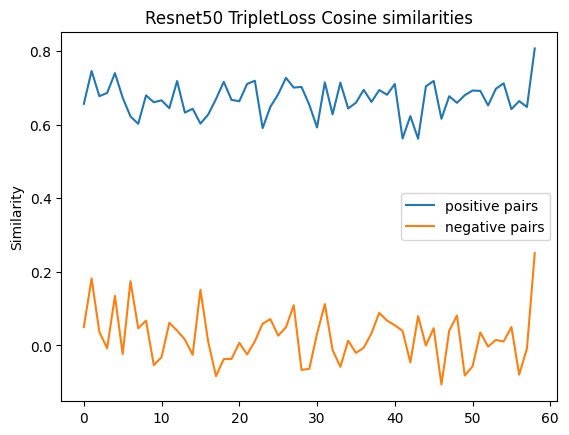

In [ ]:
plt.plot(cosine_similarities_pos, label='positive pairs')
plt.plot(cosine_similarities_neg, label='negative pairs')
plt.title('Resnet50 TripletLoss Cosine similarities')
plt.legend()
plt.ylabel('Similarity')

In [ ]:
cosine_similarities_pos = []
cosine_similarities_neg = []
for a, p, n in testloader:
    with torch.inference_mode():
        resnet_bce.eval()
        a, p, n = a.to(device), p.to(device), n.to(device)
        a_emb = normalize(resnet_bce(a)).to('cpu')
        p_emb = normalize(resnet_bce(p)).to('cpu')
        n_emb = normalize(resnet_bce(n)).to('cpu')
        cosine_similarities_pos.append(cosine_similarity(a_emb, p_emb).to('cpu'))
        cosine_similarities_neg.append(cosine_similarity(a_emb, n_emb).to('cpu'))
print(
    f"Average cos_sim_pos: {sum(cosine_similarities_pos) / len(cosine_similarities_pos)}\nAverage cos_sim_neg: {sum(cosine_similarities_neg) / len(cosine_similarities_neg)}")

C:\Users\annam\venv\pythonProject15\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Average cos_sim_pos: 0.6150410175323486
Average cos_sim_neg: 0.31848981976509094


Text(0, 0.5, 'Similarity')

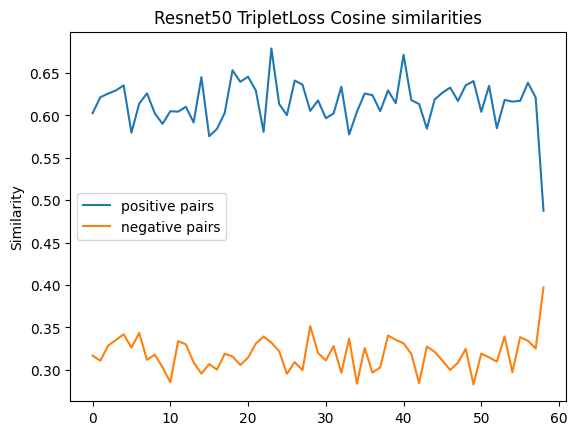

In [ ]:
plt.plot(cosine_similarities_pos, label='positive pairs')
plt.plot(cosine_similarities_neg, label='negative pairs')
plt.title('Resnet50 TripletLoss Cosine similarities')
plt.legend()
plt.ylabel('Similarity')

# Метрика для валидации модели

In [ ]:
def id_rate(model, fpr):
    q_embeddings = compute_embeddings(model, query_img_names,
                                      r'celebA_qd\celebA_query')
    d_embeddings = compute_embeddings(model, distractors_img_names,
                                      r'celebA_qd\celebA_distractors')
    cos_query_pos = compute_cosine_query_pos(query_dict,
                                             q_embeddings)
    cos_query_neg = compute_cosine_query_neg(query_dict,
                                             q_embeddings)
    cos_query_distractors = compute_cosine_query_distractors(q_embeddings, d_embeddings)
    return compute_ir(cos_query_pos, cos_query_neg, cos_query_distractors, fpr=fpr)


In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet_lb = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)
resnet_lb.fc = Identity().to(device)
resnet_lb.load_state_dict(torch.load(r'resnet_encoder.pth'))
resnet_lb.fc = nn.Linear(2048, 300).to(device)
for param in resnet_lb.layer1.parameters():
    if not isinstance(param, nn.BatchNorm2d):
        param.requires_grad = False
optimizer = optim.AdamW(resnet_lb.parameters(), 0.0003)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5)
criterion = TripletLoss(margin=0.68)

In [ ]:
torchsummary.summary(resnet_lb, (3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           9,408
       BatchNorm2d-2           [-1, 64, 80, 80]             128
              ReLU-3           [-1, 64, 80, 80]               0
         MaxPool2d-4           [-1, 64, 40, 40]               0
            Conv2d-5           [-1, 64, 40, 40]           4,096
       BatchNorm2d-6           [-1, 64, 40, 40]             128
              ReLU-7           [-1, 64, 40, 40]               0
            Conv2d-8           [-1, 64, 40, 40]          36,864
       BatchNorm2d-9           [-1, 64, 40, 40]             128
             ReLU-10           [-1, 64, 40, 40]               0
           Conv2d-11          [-1, 256, 40, 40]          16,384
      BatchNorm2d-12          [-1, 256, 40, 40]             512
           Conv2d-13          [-1, 256, 40, 40]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
def train_loop_triplet_ir(epochs, model, criterion, optimizer, trainloader, valloader, scheduler):
    results = {'train': [],
               'val': [],
               'id_rate': []}
    for epoch in range(epochs):

        model.train()
        loss = 0

        for anchor, pos, neg in tqdm(trainloader):
            optimizer.zero_grad()
            anchor = anchor.to(device)
            pos = pos.to(device)
            neg = neg.to(device)
            anch_embd = normalize(model(anchor))
            pos_embd = normalize(model(pos))
            neg_embd = normalize(model(neg))
            train_loss = criterion(anch_embd, pos_embd, neg_embd)
            train_loss.backward()
            optimizer.step()
            loss += train_loss
        results['train'].append(loss / len(trainloader))

        val_loss = 0
        loss = 0
        model.eval()
        with torch.inference_mode():
            for anchor, pos, neg in tqdm(valloader):
                anchor = anchor.to(device)
                pos = pos.to(device)
                neg = neg.to(device)
                anch_embd = normalize(model(anchor))
                pos_embd = normalize(model(pos))
                neg_embd = normalize(model(neg))
                val_loss += criterion(anch_embd, pos_embd, neg_embd)
        results['id_rate'].append(id_rate(model, 0.01))
        scheduler.step(results['id_rate'][-1])
        results['val'].append(val_loss / len(valloader))
        print(
            f"Epoch: {epoch + 1} | train_loss: {results['train'][-1]} | val_loss: {results['val'][-1]} | id_rate: {results['id_rate'][-1]}")
    return results


In [ ]:
results = train_loop_triplet_ir(20, resnet_lb, criterion, optimizer, trainloader, valloader, scheduler)

  0%|          | 0/267 [00:00<?, ?it/s]C:\Users\annam\venv\pythonProject15\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 59/59 [00:14<00:00,  4.05it/s]
C:\Users\annam\AppData\Local\Temp\ipykernel_19344\2807470317.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor

q_mean: 0.3872425854206085
d_mean: 0.9215344190597534
Epoch: 1 | train_loss: 0.1384141743183136 | val_loss: 0.1816578358411789 | id_rate: 0.17933390264731


100%|██████████| 59/59 [00:14<00:00,  3.99it/s]


q_mean: 0.4289000332355499
d_mean: 0.9181987643241882
Epoch: 2 | train_loss: 0.07597469538450241 | val_loss: 0.17481011152267456 | id_rate: 0.16225448334756618


100%|██████████| 59/59 [00:14<00:00,  4.03it/s]


q_mean: 0.4233773648738861
d_mean: 0.9376032948493958
Epoch: 3 | train_loss: 0.0455419160425663 | val_loss: 0.1646779328584671 | id_rate: 0.2143467122117848


100%|██████████| 59/59 [00:14<00:00,  4.04it/s]


q_mean: 0.4206785261631012
d_mean: 0.920852541923523
Epoch: 4 | train_loss: 0.02852236106991768 | val_loss: 0.1606091558933258 | id_rate: 0.19128949615713065


100%|██████████| 59/59 [00:14<00:00,  4.10it/s]


q_mean: 0.4380674958229065
d_mean: 0.9423284530639648
Epoch: 5 | train_loss: 0.022173220291733742 | val_loss: 0.17548711597919464 | id_rate: 0.18445772843723313


100%|██████████| 59/59 [00:14<00:00,  4.11it/s]


q_mean: 0.45127230882644653
d_mean: 0.9551642537117004
Epoch: 6 | train_loss: 0.018180307000875473 | val_loss: 0.16467417776584625 | id_rate: 0.20239111870196413


100%|██████████| 59/59 [00:13<00:00,  4.33it/s]


q_mean: 0.44345980882644653
d_mean: 0.9357606172561646
Epoch: 7 | train_loss: 0.015195776708424091 | val_loss: 0.16477686166763306 | id_rate: 0.20324508966695132


100%|██████████| 59/59 [00:13<00:00,  4.24it/s]


q_mean: 0.44460633397102356
d_mean: 0.910243034362793
Epoch: 8 | train_loss: 0.011955355294048786 | val_loss: 0.16934028267860413 | id_rate: 0.18445772843723313


100%|██████████| 59/59 [00:13<00:00,  4.32it/s]


q_mean: 0.45124176144599915
d_mean: 0.9559376835823059
Epoch: 9 | train_loss: 0.011262885294854641 | val_loss: 0.16990911960601807 | id_rate: 0.1682322801024765


100%|██████████| 59/59 [00:13<00:00,  4.30it/s]


q_mean: 0.4032961130142212
d_mean: 0.9200790524482727
Epoch: 10 | train_loss: 0.009752307087182999 | val_loss: 0.15825136005878448 | id_rate: 0.18018787361229718


100%|██████████| 59/59 [00:13<00:00,  4.29it/s]


q_mean: 0.46185916662216187
d_mean: 0.9255903959274292
Epoch: 11 | train_loss: 0.011203114874660969 | val_loss: 0.16678161919116974 | id_rate: 0.17250213492741248


100%|██████████| 59/59 [00:13<00:00,  4.31it/s]


q_mean: 0.43634462356567383
d_mean: 0.9252415299415588
Epoch: 12 | train_loss: 0.010816088877618313 | val_loss: 0.16884060204029083 | id_rate: 0.19982920580700256


100%|██████████| 59/59 [00:13<00:00,  4.31it/s]


q_mean: 0.44633930921554565
d_mean: 0.9438197016716003
Epoch: 13 | train_loss: 0.009624028578400612 | val_loss: 0.17302218079566956 | id_rate: 0.19299743808710504


  5%|▌         | 14/267 [00:06<01:51,  2.26it/s]


KeyboardInterrupt: 

# TripletLoss Online Mining

Так как обучение модели с tripletloss на датасете с предопределенными триплетами не дало хороших результатов, было решено попробовать использовать online mining, то есть подавать в лосс только выбранные эмбеддинги

Для реализации такого подхода пользовался открытым репозиторием на github:
https://github.com/KinWaiCheuk/pytorch-triplet-loss/tree/master

Так же вернемся к dataloader, который мы использовали при обучение на CrossEntropy, так как при использовании online mining, нам не нужно получать от dataloader готовые триплеты:


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import os


class CustomImageDataset(Dataset):
    def __init__(self, data_anno_path, train_split, root_dir, subset, transform=None):
        self.subset = subset
        self.data_anno_path = data_anno_path
        self.data_train_split_path = train_split
        self.root_dir = root_dir
        self.transform = transform
        self.data = self._read_txt_file()

    def _read_txt_file(self):
        with open(self.data_anno_path) as f:
            with open(self.data_train_split_path) as d:
                annot = sorted(f.readlines())
                annots = {'0': 'train',
                          '1': 'val',
                          '2': 'test'}
                train_split = sorted(d.readlines())
                data = []
                for i in range(len(annot)):
                    if annots[train_split[i].split()[1]] == self.subset:
                        annot[i] = annot[i].split()
                        annot[i].append(train_split[i].split()[1])
                        data.append((annot[i][0], int(annot[i][1]), annots[annot[i][2]]))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label, subset = self.data[idx]
        image = np.array(Image.open(os.path.join(self.root_dir, img_path)))
        image = Image.fromarray(image[77:-41, 45:-50])
        if self.transform:
            image = self.transform(image)

        return (image, label)

In [ ]:
data_anno_path = r'celeba\celebA_anno.txt'
train_split = r'celeba\celebA_train_split.txt'
root_dir = r'celeba\celebA_imgs'
transforms = tfs.Compose([
    tfs.ToTensor(),
    tfs.Resize((160, 160)),
    tfs.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_set = CustomImageDataset(data_anno_path, train_split, root_dir, 'train', transforms)
val_set = CustomImageDataset(data_anno_path, train_split, root_dir, 'val', transforms)
test_set = CustomImageDataset(data_anno_path, train_split, root_dir, 'test', transforms)

In [ ]:
trainloader = DataLoader(train_set, batch_size=128, shuffle=True)
valloader = DataLoader(val_set, batch_size=128, shuffle=False)
testloader = DataLoader(test_set, batch_size=128, shuffle=True)

In [ ]:
import os
import random
from itertools import permutations
import numpy as np
import torch


def _get_triplet_mask(labels, device='cpu'):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: torch.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = torch.eye(labels.size()[0]).type(torch.ByteTensor)  # make a index in Bool
    indices_not_equal = -(indices_equal - 1)  # flip booleans
    i_not_equal_j = torch.unsqueeze(indices_not_equal, 2)
    i_not_equal_k = torch.unsqueeze(indices_not_equal, 1)
    j_not_equal_k = torch.unsqueeze(indices_not_equal, 0)

    distinct_indices = (i_not_equal_j & i_not_equal_k) & j_not_equal_k

    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = (torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1))
    i_equal_j = torch.unsqueeze(label_equal, 2)
    i_equal_k = torch.unsqueeze(label_equal, 1)

    valid_labels = (i_equal_j & ~i_equal_k)
    # Combine the two masks

    mask = (distinct_indices.to(device).bool() & valid_labels)

    return mask


def _pairwise_distances(embeddings, squared=False, device='cpu'):
    """Compute the 2D matrix of distances between all the embeddings.
    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    embeddings = torch.squeeze(embeddings, 1)  # shape=(batch_size, features, 1)
    dot_product = torch.matmul(embeddings, torch.transpose(embeddings, 0, 1))  # shape=(batch_size, batch_size)

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = torch.diag(dot_product)
    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = torch.unsqueeze(square_norm, 1) - 2.0 * dot_product + torch.unsqueeze(square_norm, 0)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = torch.max(distances, torch.Tensor([0.0]).to(device))
    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = (distances == 0.0).float()
        distances = distances + mask * 1e-16
        distances = torch.sqrt(distances)
        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)
    # return distances matrix (batch X batch)
    return distances


def online_mine_all(labels, embeddings, margin, squared=False, device='cpu'):
    """Build the triplet loss over a batch of embeddings.
    We generate all the valid triplets and average the loss over the positive ones.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared, device=device)
    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = torch.unsqueeze(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = torch.unsqueeze(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels, device=device)
    mask = mask.float()

    triplet_loss = mask * triplet_loss

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = torch.max(triplet_loss, torch.Tensor([0.0]).to(device))

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = (triplet_loss > 1e-16).float()

    num_positive_triplets = torch.sum(valid_triplets)

    num_valid_triplets = torch.sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = torch.sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, num_positive_triplets, num_valid_triplets


def _get_anchor_positive_triplet_mask(labels, device):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.

    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]

    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = torch.eye(labels.size()[0]).bool().to(device)

    indices_not_equal = ~indices_equal  # flip booleans

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = (torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1))
    # Combine the two masks
    mask = indices_not_equal & labels_equal

    return mask


def _get_anchor_negative_triplet_mask(labels, device):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.

    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]

    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)

    mask = ~labels_equal  # invert the boolean tensor

    return mask


def online_mine_hard(labels, embeddings, margin, squared=False, device='cpu'):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared, device=device)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels, device)
    mask_anchor_positive = mask_anchor_positive

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = mask_anchor_positive * pairwise_dist

    # shape (batch_size, 1)
    hardest_positive_dist = torch.max(anchor_positive_dist, 1, keepdim=True)[0]

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels, device)
    mask_anchor_negative = mask_anchor_negative

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = torch.max(pairwise_dist, 1, keepdim=True)[0]
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * ~(mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = torch.min(anchor_negative_dist, 1, keepdim=True)[0]

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = torch.max(hardest_positive_dist - hardest_negative_dist + margin, torch.Tensor([0.0]).to(device))

    # Get final mean triplet loss
    triplet_loss = torch.mean(triplet_loss)

    return triplet_loss, torch.sum(mask_anchor_positive), torch.sum(mask_anchor_negative)

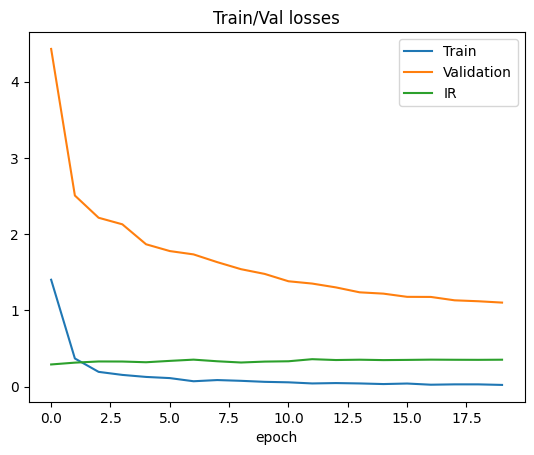

In [ ]:
plt.plot([x.to('cpu').detach() for x in results['train']], label='Train')
plt.plot([x.to('cpu').detach() for x in results['val']], label='Validation')
plt.plot(results['id_rate'], label='IR')
plt.title('Train/Val losses')
plt.xlabel('epoch')
plt.legend();

# Batch_all online mining tripletloss

In [ ]:
torch.manual_seed(42)


def train_loop_triplet_miner(epochs, model, optimizer, trainloader, valloader, scheduler):
    results = {'train': [],
               'val': [],
               'id_rate': []}
    for epoch in range(epochs):
        model.train()
        loss = 0

        for inpts, labels in tqdm(trainloader):
            optimizer.zero_grad()
            inpts, labels = inpts.to(device), labels.to(device)
            embeddings = model(inpts)
            train_loss, pos_mask, neg_mask = online_mine_all(labels, embeddings, margin=0.1, squared=False,
                                                             device=device)
            train_loss.backward()
            loss += train_loss
            optimizer.step()
        for inpts, labels in tqdm(testloader):
            optimizer.zero_grad()
            inpts, labels = inpts.to(device), labels.to(device)
            embeddings = model(inpts)
            train_loss, pos_mask, neg_mask = online_mine_all(labels, embeddings, margin=0.1, squared=False,
                                                             device=device)
            train_loss.backward()
            optimizer.step()
            loss += train_loss
        results['train'].append(loss / (len(trainloader) + len(testloader)))

        val_loss = 0
        loss = 0
        model.eval()
        with torch.inference_mode():
            for inpts, labels in tqdm(valloader):
                inpts, labels = inpts.to(device), labels.to(device)
                embeddings = model(inpts)
                val_loss += online_mine_all(labels, embeddings, margin=0.1, squared=False, device=device)[0]
        results['id_rate'].append(id_rate(model, 0.01))
        scheduler.step(results['id_rate'][-1])
        results['val'].append(val_loss / len(valloader))
        print(
            f"Epoch: {epoch + 1} | train_loss: {results['train'][-1]} | val_loss: {results['val'][-1]} | id_rate: {results['id_rate'][-1]}")
    return results

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet_lb = resnet50(weights=None).to(device)
resnet_lb.fc = Identity().to(device)
resnet_lb.load_state_dict(torch.load(r'C:\Users\annam\PycharmProjects\pythonProject15\resnet_encoder.pth'))
resnet_lb.fc = nn.Linear(2048, 512).to(device)
for param in resnet_lb.layer1.parameters():
    if not isinstance(param, nn.BatchNorm2d):
        param.requires_grad = False
optimizer = optim.Adam(resnet_lb.parameters(), 0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.3, min_lr=0.000001, patience=5)
criterion = None

In [ ]:
results_all = train_loop_triplet_miner(20, resnet_lb, optimizer, trainloader, valloader, scheduler)

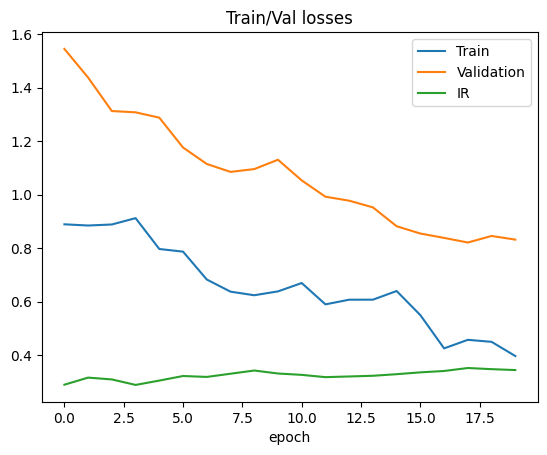

In [ ]:
plt.plot([x.to('cpu').detach() for x in results_all['train']], label='Train')
plt.plot([x.to('cpu').detach() for x in results_all['val']], label='Validation')
plt.plot(results_all['id_rate'], label='IR')
plt.title('Train/Val losses')
plt.xlabel('epoch')
plt.legend();

# Дообучение на hard mining

In [ ]:
torch.manual_seed(42)


def train_loop_triplet_miner(epochs, model, optimizer, trainloader, valloader, scheduler):
    results = {'train': [],
               'val': [],
               'id_rate': []}
    for epoch in range(epochs):
        model.train()
        loss = 0

        for inpts, labels in tqdm(trainloader):
            optimizer.zero_grad()
            inpts, labels = inpts.to(device), labels.to(device)
            embeddings = model(inpts)
            train_loss, pos_mask, neg_mask = online_mine_hard(labels, embeddings, margin=0.7, squared=False,
                                                              device=device)
            train_loss.backward()
            loss += train_loss
            optimizer.step()
        for inpts, labels in tqdm(testloader):
            optimizer.zero_grad()
            inpts, labels = inpts.to(device), labels.to(device)
            embeddings = model(inpts)
            train_loss, pos_mask, neg_mask = online_mine_hard(labels, embeddings, margin=0.7, squared=False,
                                                              device=device)
            train_loss.backward()
            optimizer.step()
            loss += train_loss
        results['train'].append(loss / (len(trainloader) + len(testloader)))

        val_loss = 0
        loss = 0
        model.eval()
        with torch.inference_mode():
            for inpts, labels in tqdm(valloader):
                inpts, labels = inpts.to(device), labels.to(device)
                embeddings = model(inpts)
                val_loss += online_mine_hard(labels, embeddings, margin=0.7, squared=False, device=device)[0]
        results['id_rate'].append(id_rate(model, 0.01))
        scheduler.step(results['id_rate'][-1])
        results['val'].append(val_loss / len(valloader))
        print(
            f"Epoch: {epoch + 1} | train_loss: {results['train'][-1]} | val_loss: {results['val'][-1]} | id_rate: {results['id_rate'][-1]}")
    return results

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet_lb = resnet50(weights=None).to(device)
resnet_lb.fc = nn.Linear(2048, 512).to(device)
resnet_lb.load_state_dict(torch.load(r'C:\Users\annam\PycharmProjects\pythonProject15\resnet_easy.pth'))
for param in resnet_lb.layer1.parameters():
    if not isinstance(param, nn.BatchNorm2d):
        param.requires_grad = False
torch.manual_seed(42)
optimizer = optim.AdamW(resnet_lb.parameters(), 0.00005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.3, min_lr=0.000001, patience=4)

In [ ]:
results_hard = train_loop_triplet_miner(30, resnet_lb, optimizer, trainloader, valloader, scheduler)

100%|██████████| 15/15 [00:34<00:00,  2.31s/it]
C:\Users\annam\AppData\Local\Temp\ipykernel_2804\2807470317.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_neg_cos = torch.cat([torch.tensor(cosine_query_distractors), torch.tensor(cosine_query_neg)])


q_mean: 0.4157181680202484
d_mean: 0.7568848729133606
Epoch: 1 | train_loss: 0.03075471892952919 | val_loss: 0.4037851095199585 | id_rate: 0.3484201537147737


100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


q_mean: 0.41775959730148315
d_mean: 0.7614947557449341
Epoch: 2 | train_loss: 0.029475882649421692 | val_loss: 0.3844667375087738 | id_rate: 0.36037574722459437


100%|██████████| 15/15 [00:34<00:00,  2.27s/it]


q_mean: 0.4142186939716339
d_mean: 0.7584108710289001
Epoch: 3 | train_loss: 0.026343340054154396 | val_loss: 0.39469966292381287 | id_rate: 0.3441502988898377


100%|██████████| 15/15 [00:34<00:00,  2.27s/it]


q_mean: 0.414269357919693
d_mean: 0.7673579454421997
Epoch: 4 | train_loss: 0.01874525658786297 | val_loss: 0.38831767439842224 | id_rate: 0.3330486763450043


100%|██████████| 15/15 [00:34<00:00,  2.31s/it]


q_mean: 0.4163661003112793
d_mean: 0.7682598829269409
Epoch: 5 | train_loss: 0.018950171768665314 | val_loss: 0.39480528235435486 | id_rate: 0.34329632792485054


100%|██████████| 15/15 [00:34<00:00,  2.28s/it]


q_mean: 0.4167790710926056
d_mean: 0.7666107416152954
Epoch: 6 | train_loss: 0.01746380515396595 | val_loss: 0.39169612526893616 | id_rate: 0.34329632792485054


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


q_mean: 0.41770830750465393
d_mean: 0.7759681940078735
Epoch: 7 | train_loss: 0.016943397000432014 | val_loss: 0.3969714045524597 | id_rate: 0.33561058923996584


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


q_mean: 0.41754812002182007
d_mean: 0.7758313417434692
Epoch: 8 | train_loss: 0.014570971019566059 | val_loss: 0.3881518840789795 | id_rate: 0.3415883859948762


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


q_mean: 0.41759759187698364
d_mean: 0.7744100093841553
Epoch: 9 | train_loss: 0.014716331847012043 | val_loss: 0.3849431872367859 | id_rate: 0.3484201537147737


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


q_mean: 0.4155711829662323
d_mean: 0.7733058929443359
Epoch: 10 | train_loss: 0.01204877533018589 | val_loss: 0.37999460101127625 | id_rate: 0.3475661827497865


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


q_mean: 0.4155174493789673
d_mean: 0.7731069326400757
Epoch: 11 | train_loss: 0.008541260845959187 | val_loss: 0.3758738338947296 | id_rate: 0.3484201537147737


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


q_mean: 0.416029155254364
d_mean: 0.7720353603363037
Epoch: 12 | train_loss: 0.008851065300405025 | val_loss: 0.37247636914253235 | id_rate: 0.3475661827497865


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


q_mean: 0.41564834117889404
d_mean: 0.7710375189781189
Epoch: 13 | train_loss: 0.00793024804443121 | val_loss: 0.37226197123527527 | id_rate: 0.3518360375747225


100%|██████████| 15/15 [00:33<00:00,  2.25s/it]


q_mean: 0.41549772024154663
d_mean: 0.771172821521759
Epoch: 14 | train_loss: 0.006718933116644621 | val_loss: 0.37087297439575195 | id_rate: 0.35269000853970967


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


q_mean: 0.4151058793067932
d_mean: 0.7717981338500977
Epoch: 15 | train_loss: 0.006627710070461035 | val_loss: 0.37142711877822876 | id_rate: 0.3561058923996584


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


q_mean: 0.4158259630203247
d_mean: 0.7722127437591553
Epoch: 16 | train_loss: 0.007937374524772167 | val_loss: 0.3705655038356781 | id_rate: 0.35012809564474806


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


q_mean: 0.41519078612327576
d_mean: 0.7718659043312073
Epoch: 17 | train_loss: 0.007547271903604269 | val_loss: 0.3700859248638153 | id_rate: 0.3561058923996584


100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


q_mean: 0.41570526361465454
d_mean: 0.7723970413208008
Epoch: 18 | train_loss: 0.0076906681060791016 | val_loss: 0.36957085132598877 | id_rate: 0.35012809564474806


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


q_mean: 0.4148797392845154
d_mean: 0.7715635299682617
Epoch: 19 | train_loss: 0.005939324386417866 | val_loss: 0.3700981140136719 | id_rate: 0.3518360375747225


100%|██████████| 15/15 [00:33<00:00,  2.25s/it]


q_mean: 0.4146420359611511
d_mean: 0.7719539999961853
Epoch: 20 | train_loss: 0.006587584502995014 | val_loss: 0.3698728680610657 | id_rate: 0.3518360375747225


100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


q_mean: 0.4154629707336426
d_mean: 0.7716987729072571
Epoch: 21 | train_loss: 0.0051893447525799274 | val_loss: 0.3702274560928345 | id_rate: 0.35098206660973524


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


q_mean: 0.4149426221847534
d_mean: 0.7717186212539673
Epoch: 22 | train_loss: 0.004216211847960949 | val_loss: 0.36937928199768066 | id_rate: 0.35012809564474806


100%|██████████| 15/15 [00:33<00:00,  2.27s/it]


q_mean: 0.41602277755737305
d_mean: 0.7732519507408142
Epoch: 23 | train_loss: 0.008902202360332012 | val_loss: 0.3689520061016083 | id_rate: 0.3484201537147737


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


q_mean: 0.4145803153514862
d_mean: 0.7702977657318115
Epoch: 24 | train_loss: 0.006389959249645472 | val_loss: 0.36930546164512634 | id_rate: 0.3518360375747225


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


q_mean: 0.4152334928512573
d_mean: 0.7711297273635864
Epoch: 25 | train_loss: 0.006272027734667063 | val_loss: 0.3690055310726166 | id_rate: 0.35269000853970967


100%|██████████| 15/15 [00:34<00:00,  2.27s/it]


q_mean: 0.41495251655578613
d_mean: 0.7711724042892456
Epoch: 26 | train_loss: 0.005473162978887558 | val_loss: 0.36957016587257385 | id_rate: 0.35098206660973524


100%|██████████| 15/15 [00:33<00:00,  2.25s/it]


q_mean: 0.4149274230003357
d_mean: 0.7722085118293762
Epoch: 27 | train_loss: 0.00583086721599102 | val_loss: 0.3699217736721039 | id_rate: 0.35098206660973524


100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


q_mean: 0.4144043028354645
d_mean: 0.7710472345352173
Epoch: 28 | train_loss: 0.006709259003400803 | val_loss: 0.37000855803489685 | id_rate: 0.35098206660973524


100%|██████████| 15/15 [00:33<00:00,  2.25s/it]


q_mean: 0.41436144709587097
d_mean: 0.7704715132713318
Epoch: 29 | train_loss: 0.005538338329643011 | val_loss: 0.3694957196712494 | id_rate: 0.35098206660973524


100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


q_mean: 0.4147080183029175
d_mean: 0.7709869742393494
Epoch: 30 | train_loss: 0.0060990857891738415 | val_loss: 0.3691346049308777 | id_rate: 0.3484201537147737


In [ ]:
torch.save(resnet_lb, r'C:\Users\annam\PycharmProjects\pythonProject15\resnet_hard_mining.pth')

In [ ]:
fprs = [0.5, 0.2, 0.1, 0.05]
for fpr in fprs:
    print(f"FPR={fpr} | ID_rate: {id_rate(resnet_lb, fpr)}")

q_mean: 0.4147080183029175
d_mean: 0.7709869742393494
FPR=0.5 | ID_rate: 0.9923142613151152


C:\Users\annam\AppData\Local\Temp\ipykernel_2804\2807470317.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_neg_cos = torch.cat([torch.tensor(cosine_query_distractors), torch.tensor(cosine_query_neg)])


q_mean: 0.4147080183029175
d_mean: 0.7709869742393494
FPR=0.2 | ID_rate: 0.9086251067463706
q_mean: 0.4147080183029175
d_mean: 0.7709869742393494
FPR=0.1 | ID_rate: 0.8198121263877028
q_mean: 0.4147080183029175
d_mean: 0.7709869742393494
FPR=0.05 | ID_rate: 0.6746370623398804


Модель обученная по стратегии  batch_all, а после дообученная на hard mining смогла опередить CE лосс по метрики Identification_rate при всех fpr, кроме fpr=0.01)
Результаты CE:



*   FPR=0.5: 0.977796754910333
*   FPR=0.2: 0.888129803586678
*   FPR=0.1: 0.7677198975234842
*   FPR=0.01: 0.39453458582408196











Подводя итоги обучения модели на tripletloss, хотелось бы отметить что этот лосс крайне тяжело использовать для обучения с малыми ресурсами, так как основной его потенциал раскрывается на моделях с большими выходными слоями и огромным батчасайзом на hard mining. Добиться результатов лучших чем на CrossEntropyLoss позволило поочередное обучение сначало на всех триплетах, а далее еще 30 эпох с маленьким lr на hard mining. Для обучения на триплетлосс было принято для обучения использовать еще и testset, так как метрики модели измерялись на других данных. К сожалению это не дало существенного прироста метрикам модели. Причиной этого могло быть малое разнообразие классов относительно тренировочного датасета